## this nb uses expo instead of pre data,. This nb excludes c18m9 due to expo imaging not mathcing up with other sessions (due to different zoom)

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_four_odors_across_combined_ALL_redo_EXPOdata'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
import numpy as np
cv = LeaveOneOut()

decoder = LinearSVC()

In [7]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells, test_labels_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells, test_labels_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns_within(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

def combine_train_test_patterns_within(patterns, labels, classes=None, n_cells=None,train_test_split=0.5,
                                relabel=None, relabel_test=None):
    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
## OK, SO I HAD TROUBLE WITH THIS. YOU CAN NOT SEPARATELY SELECT A RANDOM PERMUTATION OF CELLS ACROSS SESSIONS, OR ELSE
## YOUR DECODER WILL BE USING DIFFERENT IDENTITY CELLS WHEN TRAINING AND TESTING!!!!!    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])

In [8]:
#for confusion matrix (use predict instead of score)
#def do_prediction_combined_across(patterns_train,labels_train,patterns_test,labels_test,ncells=None,n_steps=10,**args):
#    
#    #scores, test_labels = do_predict_across(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
#    
#    if ncells is None:
#        total_n = np.sum([patterns_train[ani].shape[1] for ani in patterns_train.keys()])
#        ncells = np.r_[np.linspace(2, total_n, n_steps).astype(int)]
#    else:
#        ncells = np.r_[np.linspace(2, ncells, n_steps).astype(int)]
#        
#    #test_scores_ncells, test_labels_ncells,train_scores_ncells,train_labels_ncells = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,train_test_split=0.5,n_cells=n,**args) for n in ncells]]
#    ncells_scores = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,n_cells=n,**args) for n in ncells]]
#    
#    return ncells_scores,ncells

def do_predict_cross_session(patterns_t, labels_t, patterns_T, labels_T, n_cells=None, classes=None,train_test_split=0.5,relabel=None):
    if classes==None:
        classes=[0,1]
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l >=0:
                wt = np.random.permutation(np.where(labels_t[ani]==l)[0])
                if train_test_split<1:
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                else:
                    which_trains.append(wt)
                wT = np.random.permutation(np.where(labels_T[ani]==l)[0])
                if train_test_split<1:
                    which_tests.append(wT[:int(len(wT)*train_test_split)])
                    which_tests.append(wT)
                else:
                    which_tests.append(wT)
        which_train[ani] = np.concatenate(which_trains)
        which_test[ani] = np.concatenate(which_tests)       
                
    
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]
        
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_dt, labels_dt,classes=classes)
    patterns_comb_test, labels_comb_ = ut.combine_patterns(patterns_dT, labels_dT,classes=classes)
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        #print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    prediction_test = decoder.predict(patterns_comb_test[:, cells])
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    prediction_train = decoder.predict(patterns_comb_train[:, cells])
    return prediction_train,prediction_test,labels_comb

In [9]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=.35)
    ax.tick_params(axis='both', which='both', bottom=False, left=False,pad=-1)
    
    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
# excluding c18m9
vhpc_expo_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_pre_animals =  '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_post_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_post_hiatus_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'

dhpc_expo_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_pre_animals =  'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_post_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_post_hiatus_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'

In [11]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [63]:
regions = 'dhpc','vhpc'
sessions = 'expo','post','post_hiatus'
CR_comparisons = 'expopost','expopost_hiatus','postpost_hiatus' #exclude expo session, since did not cellreg this
durations=([0,1],[1,2],[2,3],[3,4],[4,5],[5,6])
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
classes = range(1,5)

In [13]:
for reg in regions:
    for sess in sessions:
        for var in ('time_ax', 'traces', 'events', 'cycles',
            'is_STIM1t', 'is_STIM2t', 'is_STIM3t', 'is_STIM4t','CYCLE_START', 'CS_DURATION', 'DELAY'):
            exec ('%s_%s_%s = {}'%(var,reg, sess))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                if sess == 'expo':
                    folder = '../%s/4_odor_expo/notebooks/autorestore/preprocessing'%(ani)
                else:
                    folder = '../%s/%s/notebooks/autorestore/preprocessing'%(ani,sess)
                try:
                    eval('%s_%s_%s'%(var,reg,sess)).update({ani: ut.load_variable(var, folder)})
                except IOError:
                    print 'error'
                    continue

In [14]:
for reg in regions:
    for tb in bins:
        for sess in sessions:
            try:
                exec("patterns_%s_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))
            except:
                print 'nope %s %s'%(tb,sess)
#get patterns of cells registered across all 3 sessions
        for sess in ['expo','post','post_hiatus']: #leave out pre since did not register to this session
            exec("cellreg_patterns_%s_%s_reg_w_all_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_reg_%s_%s_all',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels_%s',\
                                                                 '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))

In [15]:
for reg in regions:
    for sess in sessions:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s_%s['%s'] = patterns_%s_%s_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('cellreg_patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    exec("cellreg_patterns_%s_%s_%s_%s['%s'] = cellreg_patterns_%s_%s_reg_w_all_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))

In [78]:
for reg in regions:
    for sess in sessions:
        exec("%s_%s = 0"%(reg,sess))
        for key in eval("patterns_%s_1s_%s.keys()"%(reg,sess)):
            exec("%s_%s = %s_%s + np.shape(patterns_%s_1s_%s[key])[-1]"%(reg,sess,reg,sess,reg,sess))
        print reg,sess,eval("%s_%s"%(reg,sess))

dhpc expo 1698
dhpc post 1264
dhpc post_hiatus 1396
vhpc expo 361
vhpc post 260
vhpc post_hiatus 280


In [71]:
d_cells = 0
for key in cellreg_patterns_dhpc_1s_reg_w_all_post:
    d_cells = d_cells+np.shape(cellreg_patterns_dhpc_1s_reg_w_all_post[key])[-1]
print d_cells

v_cells = 0
for key in cellreg_patterns_vhpc_1s_post_0:
    v_cells = v_cells+np.shape(cellreg_patterns_vhpc_1s_reg_w_all_post[key])[-1]
print v_cells

503
104


In [83]:
for reg in regions:
    for sess in sessions:
        print reg,sess, eval("%s_cells*1.0/%s_%s"%(reg[0],reg,sess))

dhpc expo 0.296230859835
dhpc post 0.397943037975
dhpc post_hiatus 0.360315186246
vhpc expo 0.288088642659
vhpc post 0.4
vhpc post_hiatus 0.371428571429


In [17]:
loops=100
cell_quant=[20,40,60,80,100]

In [18]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for cr,sess in zip(CR_comparisons,[['expo','post'],['expo','post_hiatus'],['post','post_hiatus']]):
        print reg,cr
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("test_predictions_%s_%s_%s_%s_%s_%scells,train_predictions_%s_%s_%s_%s_%s_%scells,\
                        labels = do_predict_cross_session(cellreg_patterns_%s_%s_%s_%s,labels_%s_%s,cellreg_patterns_%s_%s_%s_%s,\
                        labels_%s_%s,n_cells=q,classes=range(1, 5))"\
                        %(reg,tb,cr,t,n,q,reg,tb,cr,t,n,q,reg,tb,sess[0],t,reg,sess[0],reg,tb,sess[1],t,reg,sess[1]))

computing loop: dhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 2d 2h 49min 40s, sys: 2h 35min 14s, total: 2d 5h 24min 54s
Wall time: 4h 53min 38s



In [19]:
%%time
relabel = {1:0, 2:0, 3:1, 4:1}
#for time bins durations of 0.5 and 1s, predict CS+ or CS- for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for cr,sess in zip(CR_comparisons,[['expo','post'],['expo','post_hiatus'],['post','post_hiatus']]):
        print reg,cr
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("CSpm_test_predictions_%s_%s_%s_%s_%s_%scells,CSpm_train_predictions_%s_%s_%s_%s_%s_%scells,\
                        CSpm_labels = do_predict_cross_session(cellreg_patterns_%s_%s_%s_%s,labels_%s_%s,cellreg_patterns_%s_%s_%s_%s,\
                        labels_%s_%s,n_cells=q,classes=range(1, 5),relabel=relabel)"\
                        %(reg,tb,cr,t,n,q,reg,tb,cr,t,n,q,reg,tb,sess[0],t,reg,sess[0],reg,tb,sess[1],t,reg,sess[1]))

computing loop: dhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 23h 44min 26s, sys: 1h 8min 36s, total: 1d 53min 2s
Wall time: 3h 28min 1s



In [20]:
%%time
#for time bins durations of 0.5 and 1s, predict CS+ or CS- for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("predictions_%s_%s_%s_%s_%s_%scells,_ = do_predict_within(cellreg_patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(1, 5),n_cells=q)"%(reg,tb,sess,t,n,q,reg,tb,sess,t,reg,sess))

computing loop: dhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 1d 8h 18min 35s, sys: 1h 39min 22s, total: 1d 9h 57min 57s
Wall time: 3h 1min 30s



In [21]:
%%time
#for time bins durations of 0.5 and 1s, predict CS+ or CS- for each bin. Repeat n times (where n = loops). This takes a while
relabel = {1:0, 2:0, 3:1, 4:1}
print 'computing loop:',
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("CSpm_predictions_%s_%s_%s_%s_%s_%scells,_ = do_predict_within(cellreg_patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(1, 5),n_cells=q,relabel=relabel)"%(reg,tb,sess,t,n,q,reg,tb,sess,t,reg,sess))

computing loop: dhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 17h 36min 52s, sys: 51min 1s, total: 18h 27min 54s
Wall time: 2h 33min 14s



In [22]:
#append all loops
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("test_predictions_%s_%s_%s_%s_%scells_appended = np.append(test_predictions_%s_%s_%s_%s_0_%scells,\
                          test_predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    labels_appended = np.append(labels,labels)
                    for n in range(2,loops):
                        exec("test_predictions_%s_%s_%s_%s_%scells_appended = np.append(test_predictions_%s_%s_%s_%s_%scells_appended\
                        ,test_predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))
                        labels_appended = np.append(labels_appended,labels)

                    exec("train_predictions_%s_%s_%s_%s_%scells_appended = np.append(train_predictions_%s_%s_%s_%s_0_%scells,\
                          train_predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("train_predictions_%s_%s_%s_%s_%scells_appended = np.append(train_predictions_%s_%s_%s_%s_%scells_appended\
                        ,train_predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [23]:
#append all loops
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("CSpm_test_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_test_predictions_%s_%s_%s_%s_0_%scells,\
                          CSpm_test_predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    CSpm_labels_appended = np.append(CSpm_labels,CSpm_labels)
                    for n in range(2,loops):
                        exec("CSpm_test_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_test_predictions_%s_%s_%s_%s_%scells_appended\
                        ,CSpm_test_predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))
                        CSpm_labels_appended = np.append(CSpm_labels_appended,CSpm_labels)

                    exec("CSpm_train_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_train_predictions_%s_%s_%s_%s_0_%scells,\
                          CSpm_train_predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("CSpm_train_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_train_predictions_%s_%s_%s_%s_%scells_appended\
                        ,CSpm_train_predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [24]:
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    CSpm_labels_appended = np.append(CSpm_labels,CSpm_labels)
                    for n in range(2,loops):
                        CSpm_labels_appended = np.append(CSpm_labels_appended,CSpm_labels)

In [25]:
#append all loops
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("predictions_%s_%s_%s_%s_%scells_appended = np.append(predictions_%s_%s_%s_%s_0_%scells,\
                          predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("predictions_%s_%s_%s_%s_%scells_appended = np.append(predictions_%s_%s_%s_%s_%scells_appended\
                        ,predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [26]:
#append all loops
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("CSpm_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_predictions_%s_%s_%s_%s_0_%scells,\
                          CSpm_predictions_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("CSpm_predictions_%s_%s_%s_%s_%scells_appended = np.append(CSpm_predictions_%s_%s_%s_%s_%scells_appended\
                        ,CSpm_predictions_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [27]:
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec('conf_matr_test_%s_%s_%s_%s_%scells_appended = confusion_matrix(labels_appended,\
                          test_predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

                    exec('conf_matr_train_%s_%s_%s_%s_%scells_appended = confusion_matrix(labels_appended,\
                          train_predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

In [28]:
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec('CSpm_conf_matr_test_%s_%s_%s_%s_%scells_appended = confusion_matrix(CSpm_labels_appended,\
                          CSpm_test_predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

                    exec('CSpm_conf_matr_train_%s_%s_%s_%s_%scells_appended = confusion_matrix(CSpm_labels_appended,\
                          CSpm_train_predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

In [29]:
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec('conf_matr_%s_%s_%s_%s_%scells_appended = confusion_matrix(labels_appended,\
                          predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

In [30]:
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec('CSpm_conf_matr_%s_%s_%s_%s_%scells_appended = confusion_matrix(CSpm_labels_appended,\
                          CSpm_predictions_%s_%s_%s_%s_%scells_appended)'%(reg,tb,sess,t,q,reg,tb,sess,t,q))

In [31]:
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for q in cell_quant:
                exec("heatmaps_test_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("heatmaps_test_%s_%s_%s_%scells.append(conf_matr_test_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

                exec("heatmaps_train_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("heatmaps_train_%s_%s_%s_%scells.append(conf_matr_train_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

In [32]:
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for q in cell_quant:
                exec("CSpm_heatmaps_test_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("CSpm_heatmaps_test_%s_%s_%s_%scells.append(CSpm_conf_matr_test_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

                exec("CSpm_heatmaps_train_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("CSpm_heatmaps_train_%s_%s_%s_%scells.append(CSpm_conf_matr_train_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

In [33]:
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for q in cell_quant:
                exec("heatmaps_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("heatmaps_%s_%s_%s_%scells.append(conf_matr_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

                exec("CSpm_heatmaps_%s_%s_%s_%scells = []"%(reg,tb,sess,q))
                for t in range(bin_ranges[i]): # number of time bins
                    exec("CSpm_heatmaps_%s_%s_%s_%scells.append(CSpm_conf_matr_%s_%s_%s_%s_%scells_appended)"%(reg,tb,sess,q,reg,tb,sess,t,q))

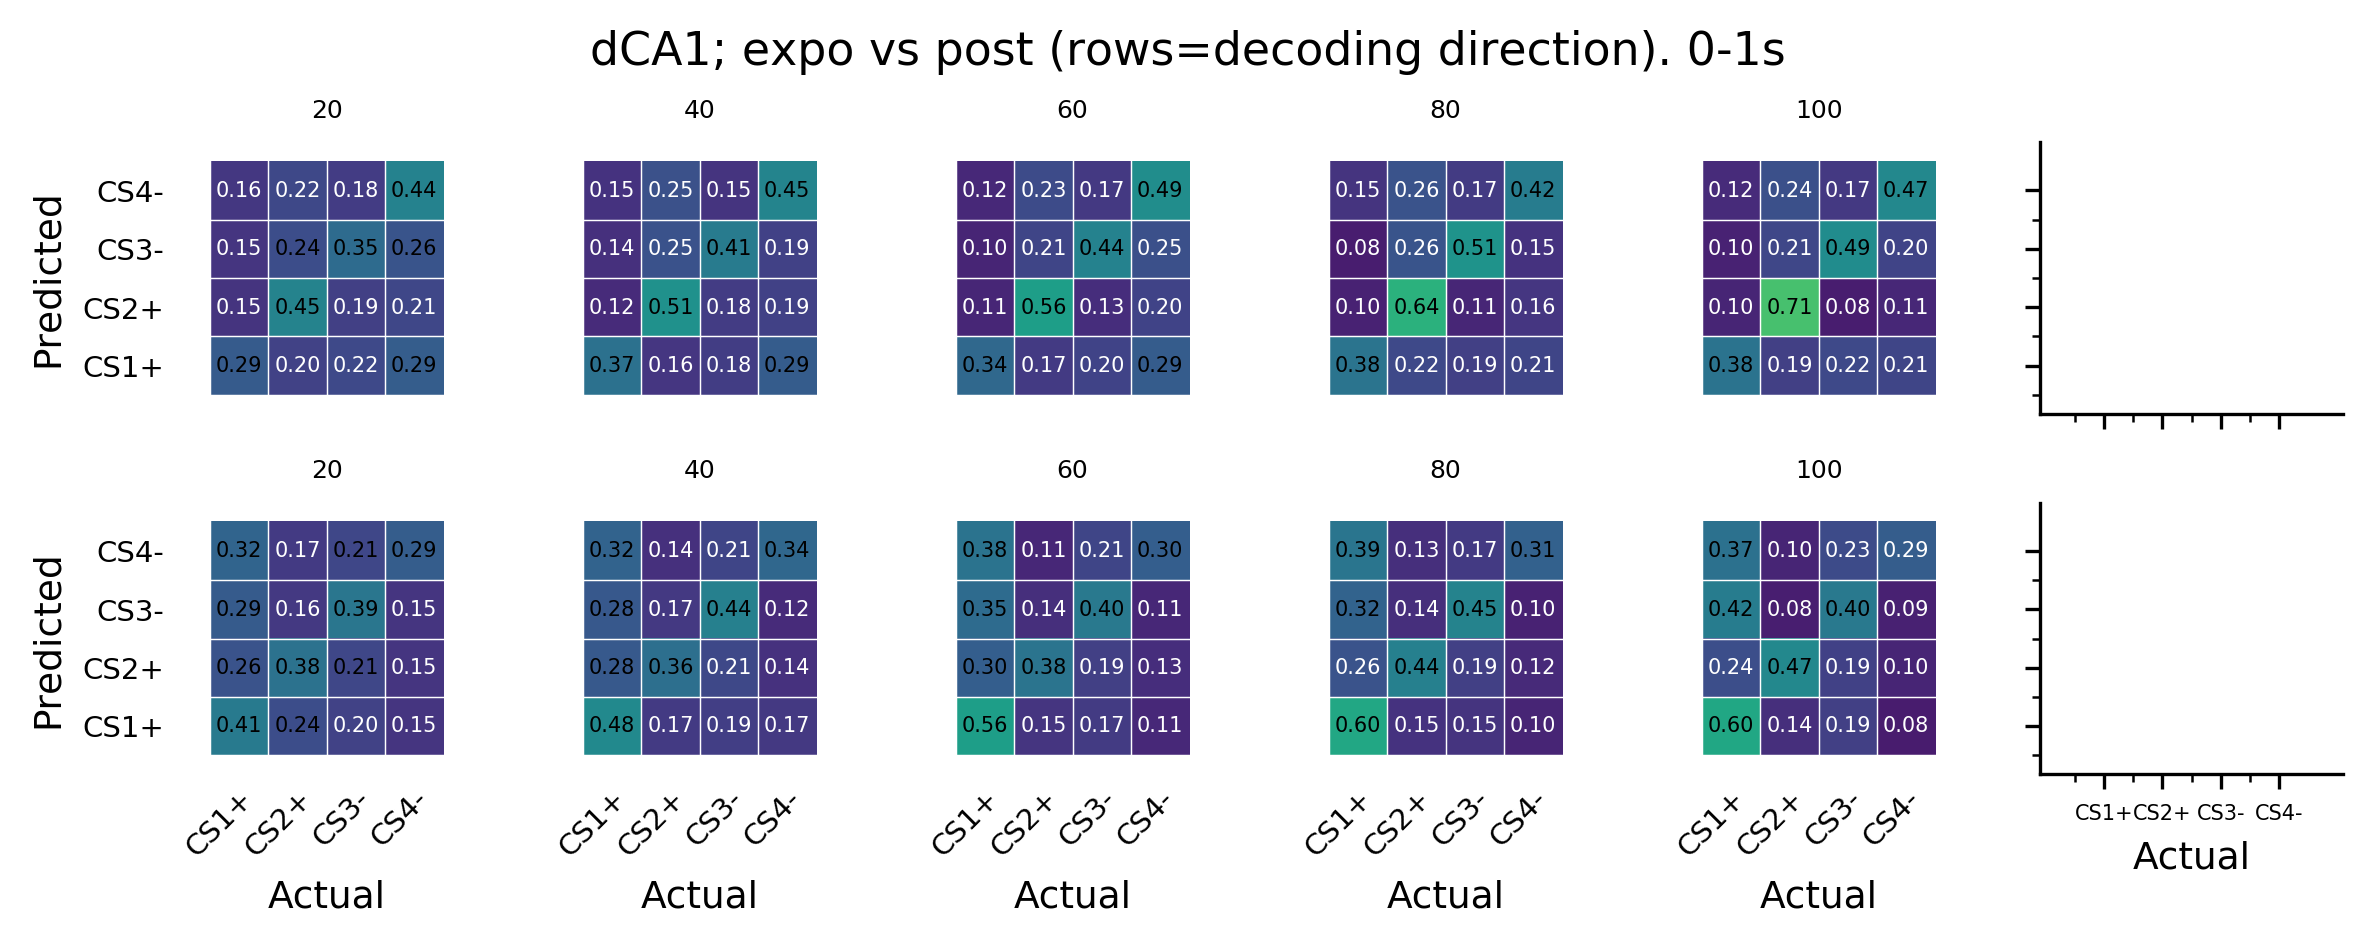

In [47]:
# plot 'em all
sess='expopost'
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(8, 3),sharex=True,sharey=True)

for way,r,la1 in zip(('test','train'),(0,6),('post vs post_hiatus','post_hiatus vs post')):
    for i,j in zip(cell_quant,range(1,7)):
        q=j+r
        im = heatmap(eval("4.*heatmaps_%s_dhpc_1s_%s_%scells[5]/np.sum(heatmaps_%s_dhpc_1s_%s_%scells[5])"%(way,sess,i,way,sess,i)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s"'%(i)),fontsize=6)
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('dCA1; expo vs post (rows=decoding direction). 0-1s',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_vhpc_expopost_1s.pdf'%NOTEBOOK_NAME)

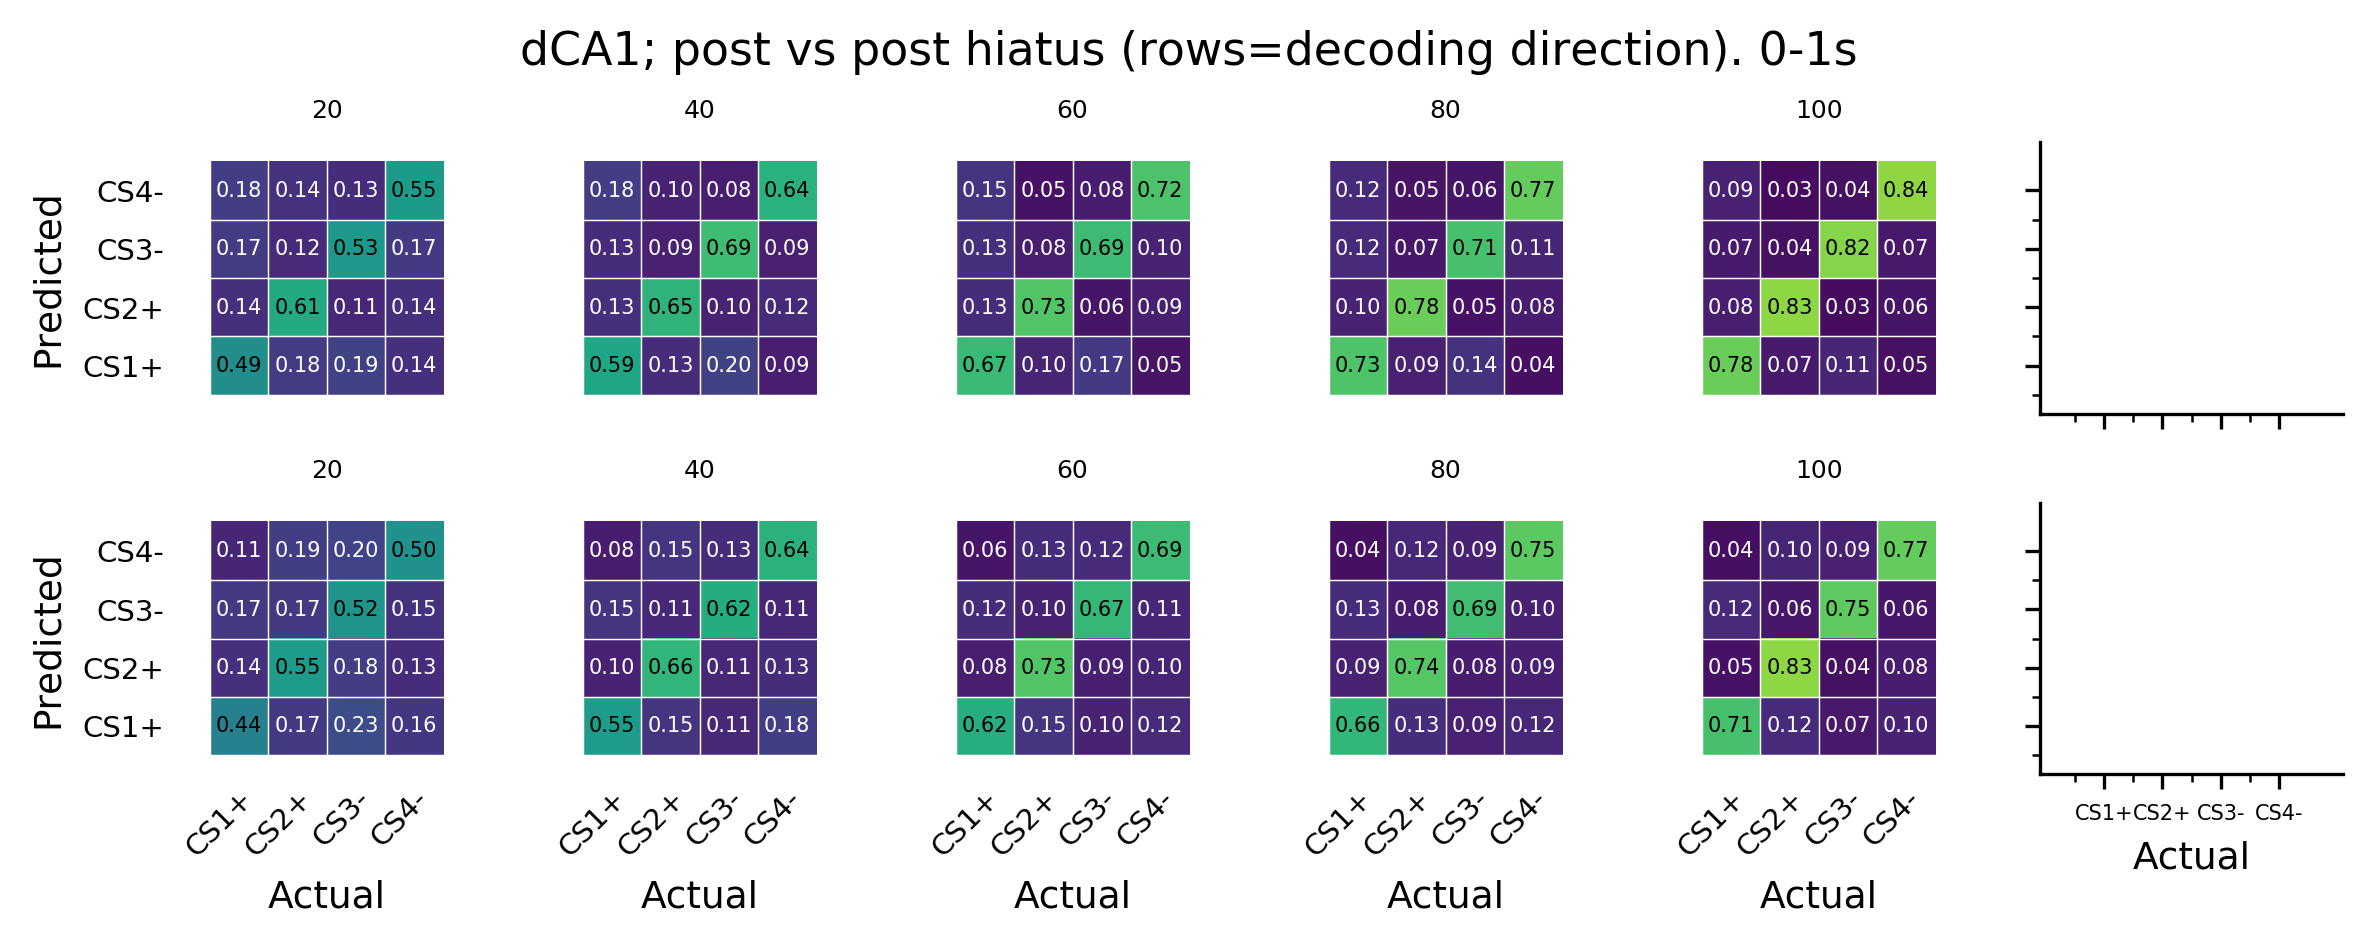

In [35]:
# plot 'em all
sess='postpost_hiatus'
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(8, 3),sharex=True,sharey=True)

for way,r,la1 in zip(('test','train'),(0,6),('post vs post_hiatus','post_hiatus vs post')):
    for i,j in zip(cell_quant,range(1,7)):
        q=j+r
        im = heatmap(eval("4.*heatmaps_%s_dhpc_1s_%s_%scells[5]/np.sum(heatmaps_%s_dhpc_1s_%s_%scells[5])"%(way,sess,i,way,sess,i)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s"'%(i)),fontsize=6)
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('dCA1; post vs post hiatus (rows=decoding direction). 0-1s',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_vhpc_expopost_1s.pdf'%NOTEBOOK_NAME)

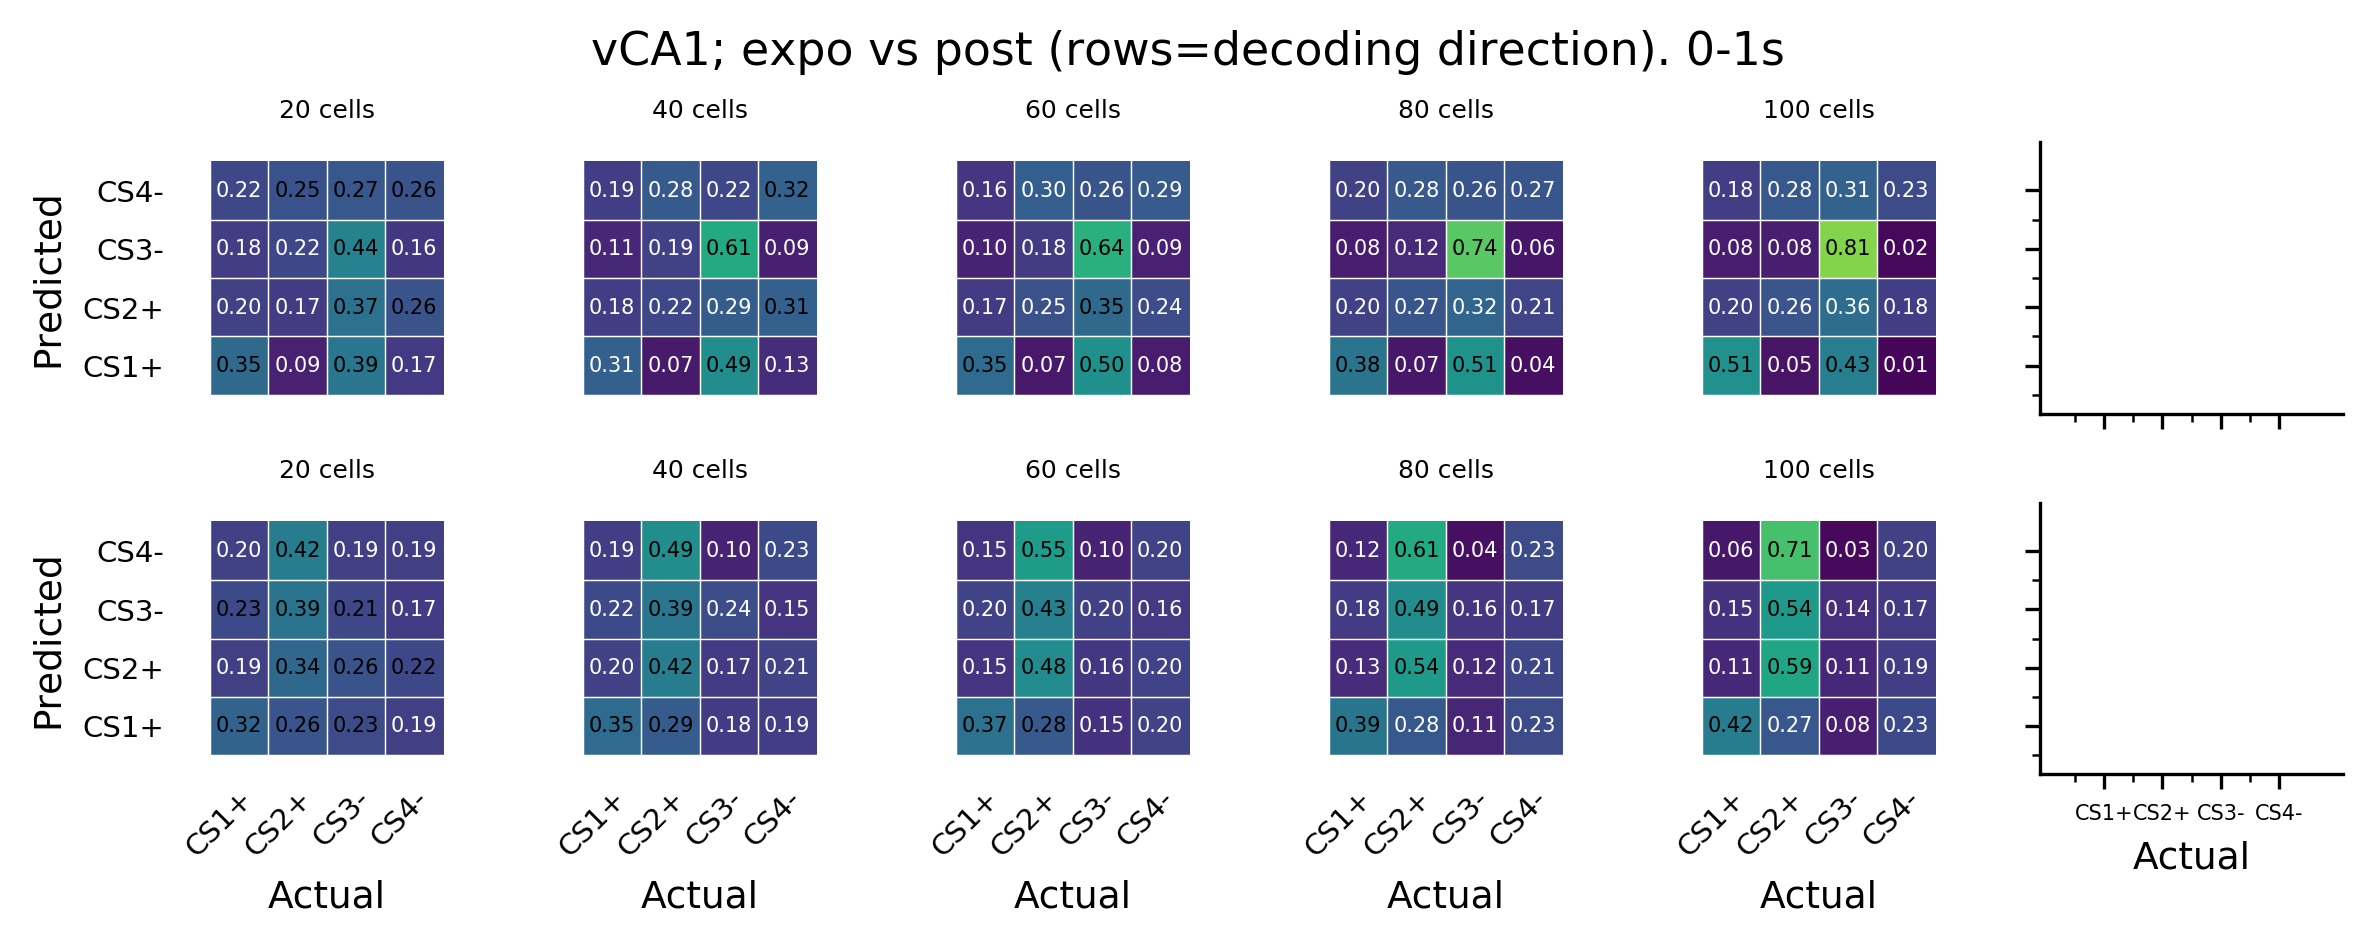

In [48]:
# plot 'em all
sess='expopost'
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(8, 3),sharex=True,sharey=True)

for way,r,la1 in zip(('test','train'),(0,6),('post vs post_hiatus','post_hiatus vs post')):
    for i,j in zip(cell_quant,range(1,7)):
        q=j+r
        im = heatmap(eval("4.*heatmaps_%s_vhpc_1s_%s_%scells[5]/np.sum(heatmaps_%s_vhpc_1s_%s_%scells[5])"%(way,sess,i,way,sess,i)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s cells"'%(i)),fontsize=6)
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('vCA1; expo vs post (rows=decoding direction). 0-1s',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_vhpc_expopost_1s.pdf'%NOTEBOOK_NAME)

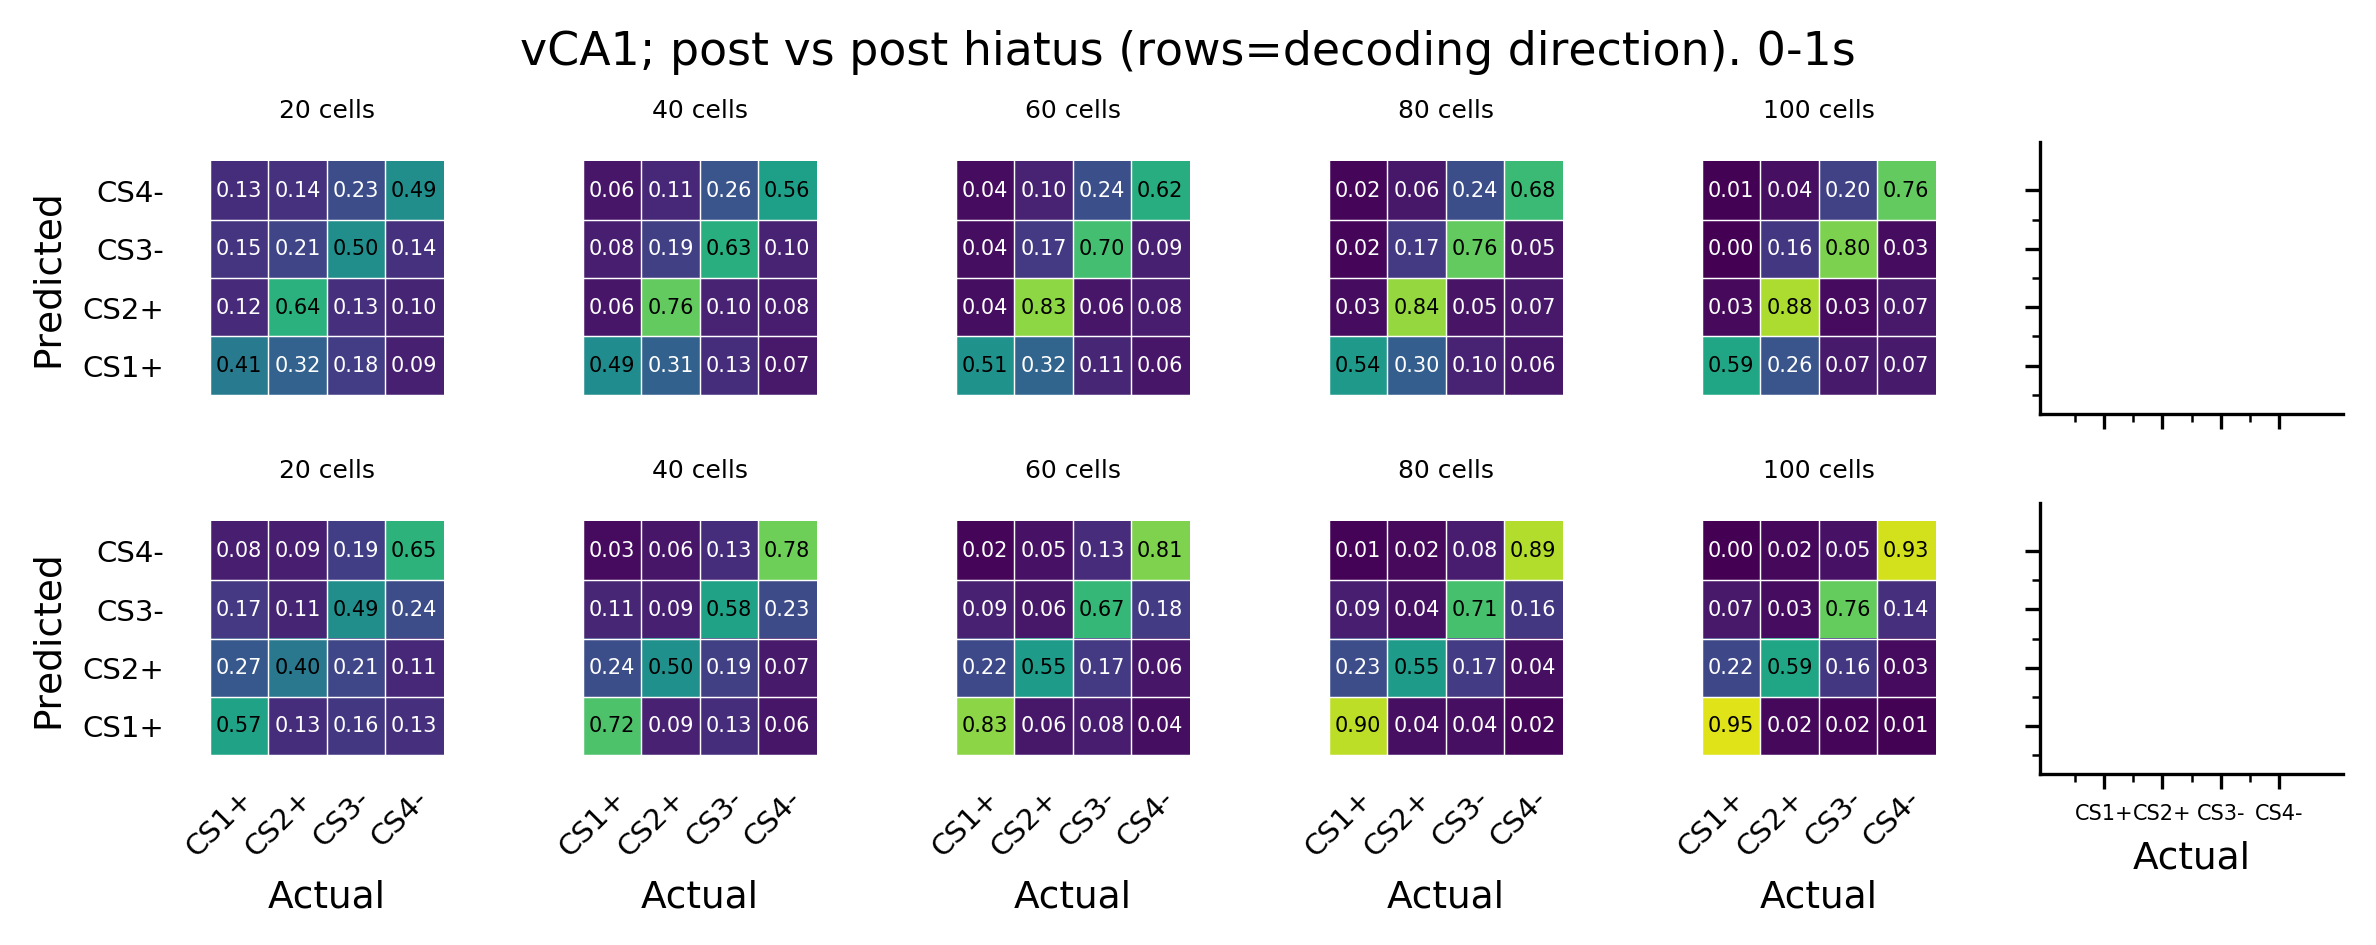

In [37]:
# plot 'em all
sess='postpost_hiatus'
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12)) = pl.subplots(2, 6, figsize=(8, 3),sharex=True,sharey=True)

for way,r,la1 in zip(('test','train'),(0,6),('post vs post_hiatus','post_hiatus vs post')):
    for i,j in zip(cell_quant,range(1,7)):
        q=j+r
        im = heatmap(eval("4.*heatmaps_%s_vhpc_1s_%s_%scells[5]/np.sum(heatmaps_%s_vhpc_1s_%s_%scells[5])"%(way,sess,i,way,sess,i)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
        annotate_heatmap(im, valfmt="{x:.2f}", size=5)
        eval('ax%s'%q).set_title(eval('"%s cells"'%(i)),fontsize=6)
for x in range(7,13):
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=9)
for x in 1,7:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=9)
pl.suptitle('vCA1; post vs post hiatus (rows=decoding direction). 0-1s',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
#fig.savefig('../figures/%s_vhpc_expopost_1s.pdf'%NOTEBOOK_NAME)

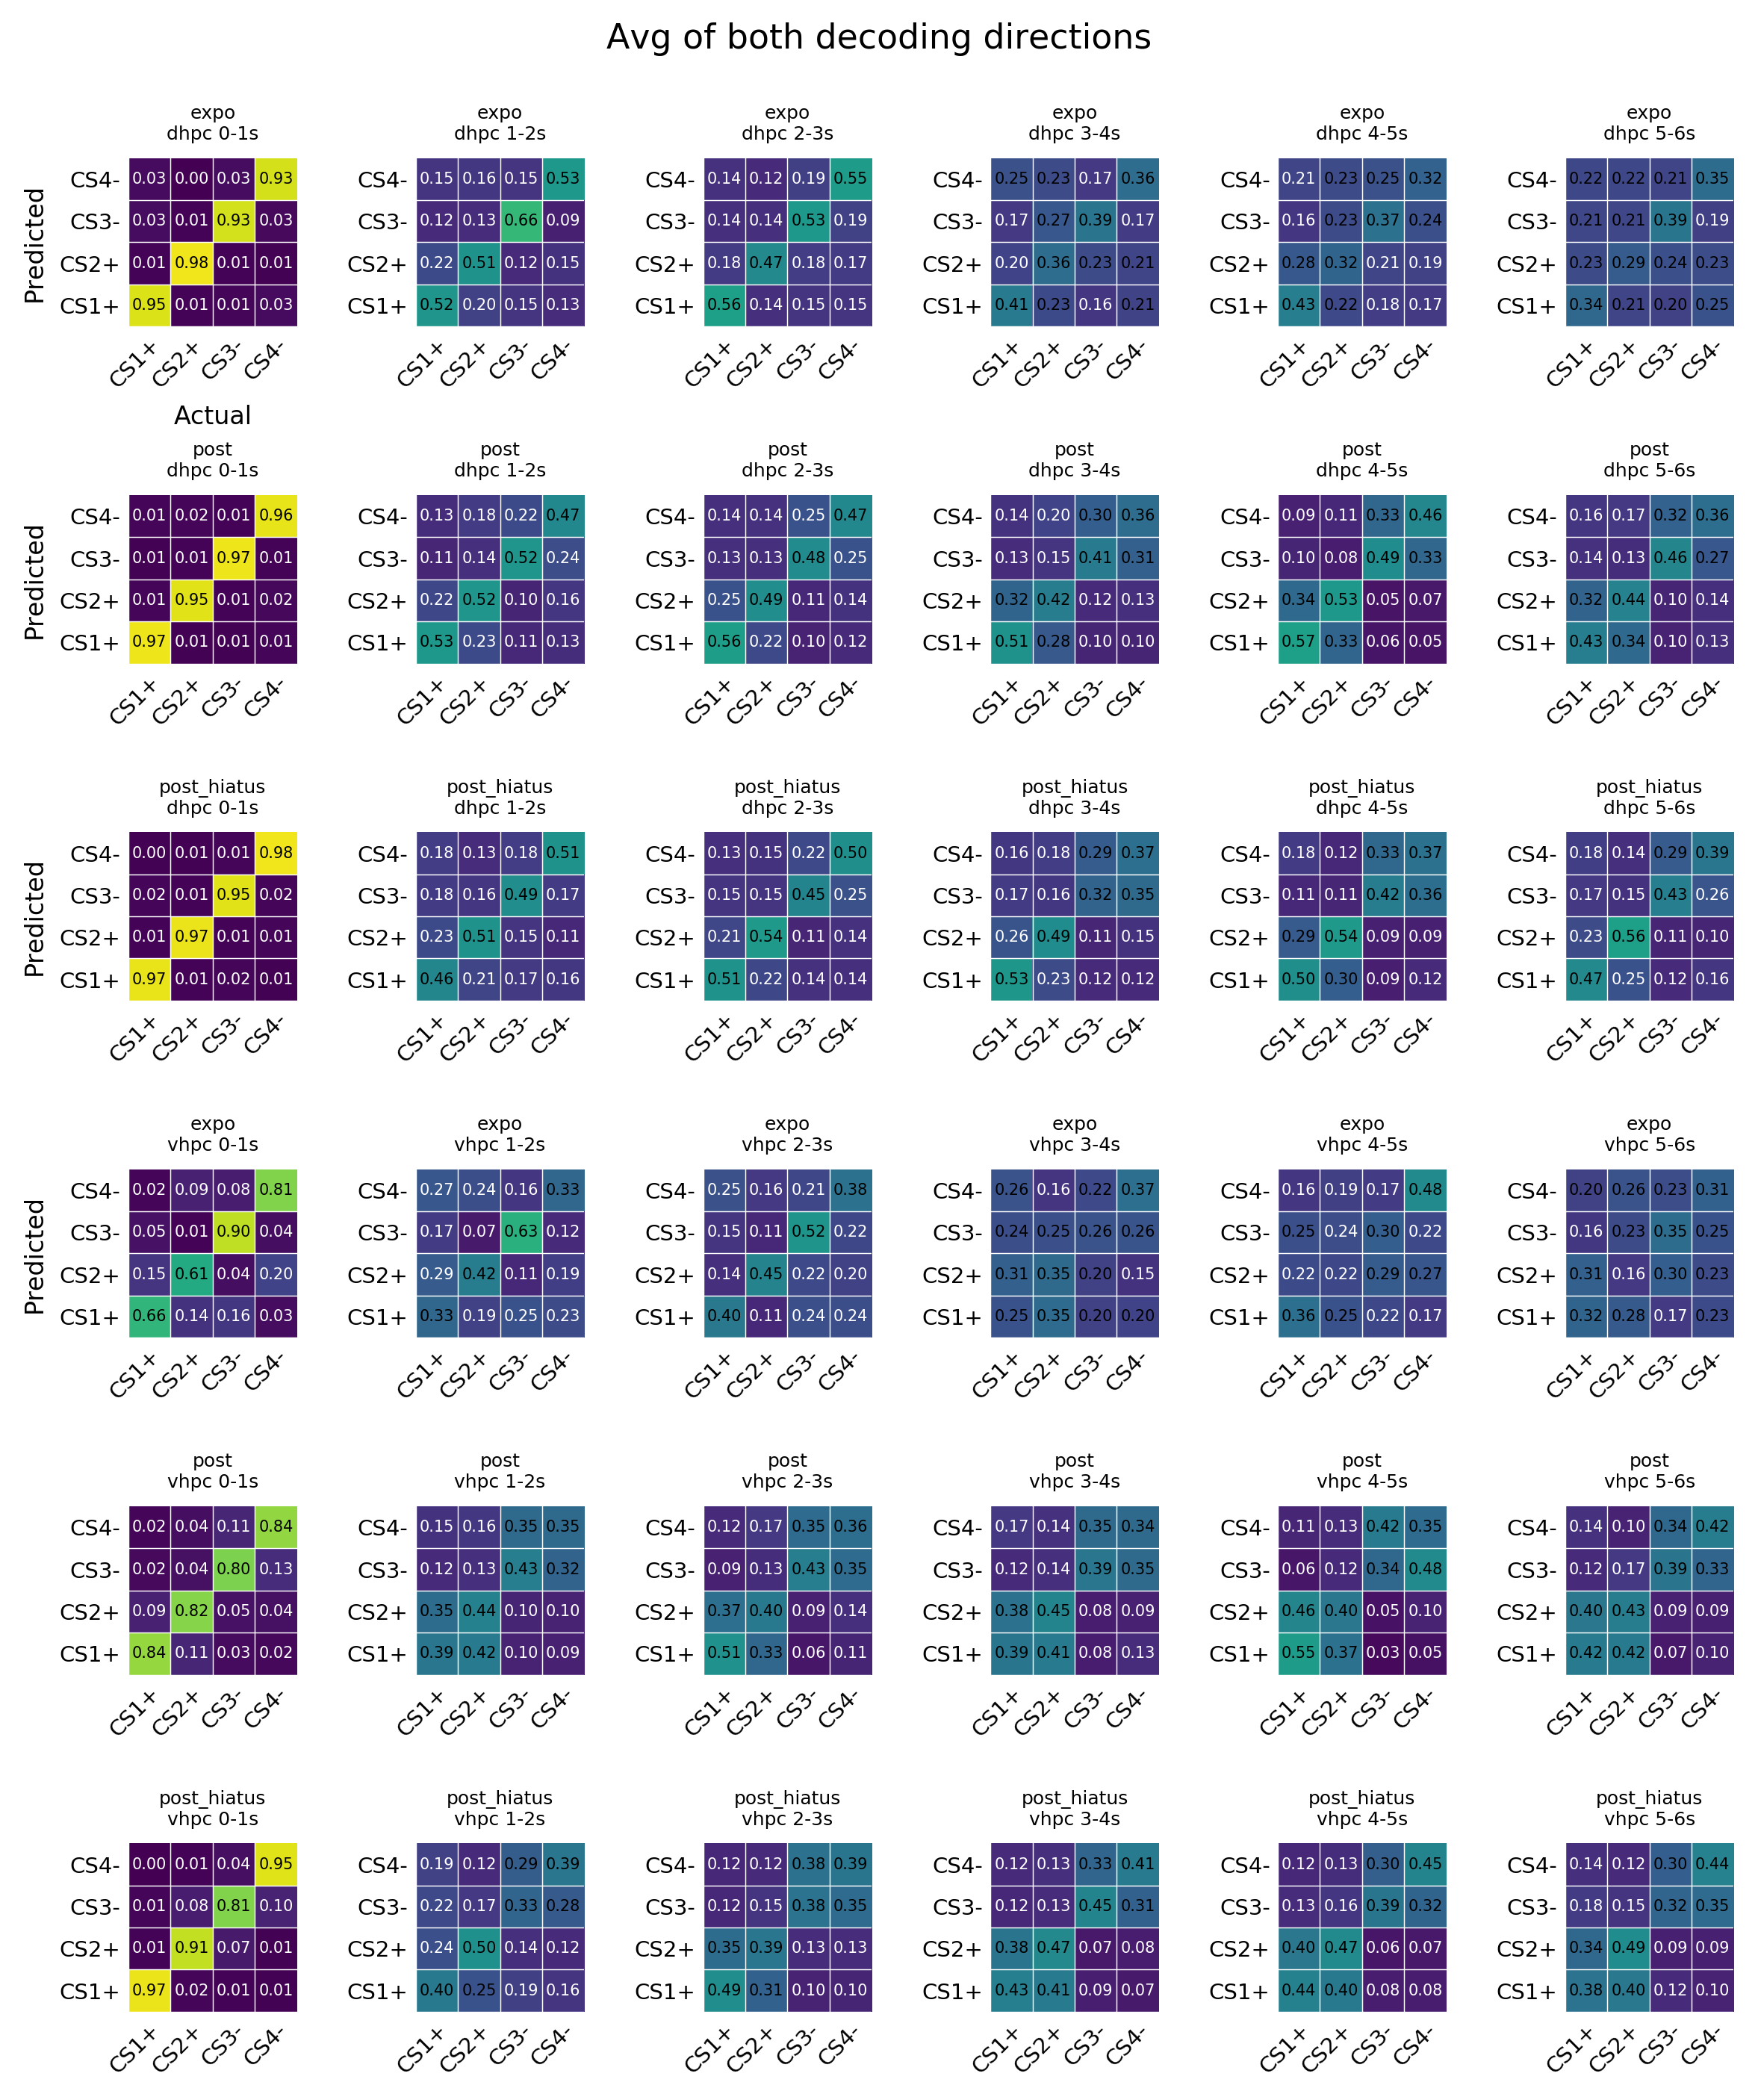

In [38]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),
      (ax19,ax20,ax21,ax22,ax23,ax24),(ax25,ax26,ax27,ax28,ax29,ax30),(ax31,ax32,ax33,ax34,ax35,ax36)) = pl.subplots(6, 6, figsize=(8, 9))

for reg,r in zip(regions,(0,18)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['expo','post','post_hiatus'],[0,6,12]):
            q=j+k+r
            im = heatmap(eval("4.*np.mean((heatmaps_%s_1s_%s_100cells,heatmaps_%s_1s_%s_100cells),0)[i]/np.sum(heatmaps_%s_1s_%s_100cells[i])"%(reg,comp,reg,comp,reg,comp)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                         (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 1,:
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=8)
pl.suptitle('Avg of both decoding directions',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_4odor_win_1s.pdf'%NOTEBOOK_NAME)

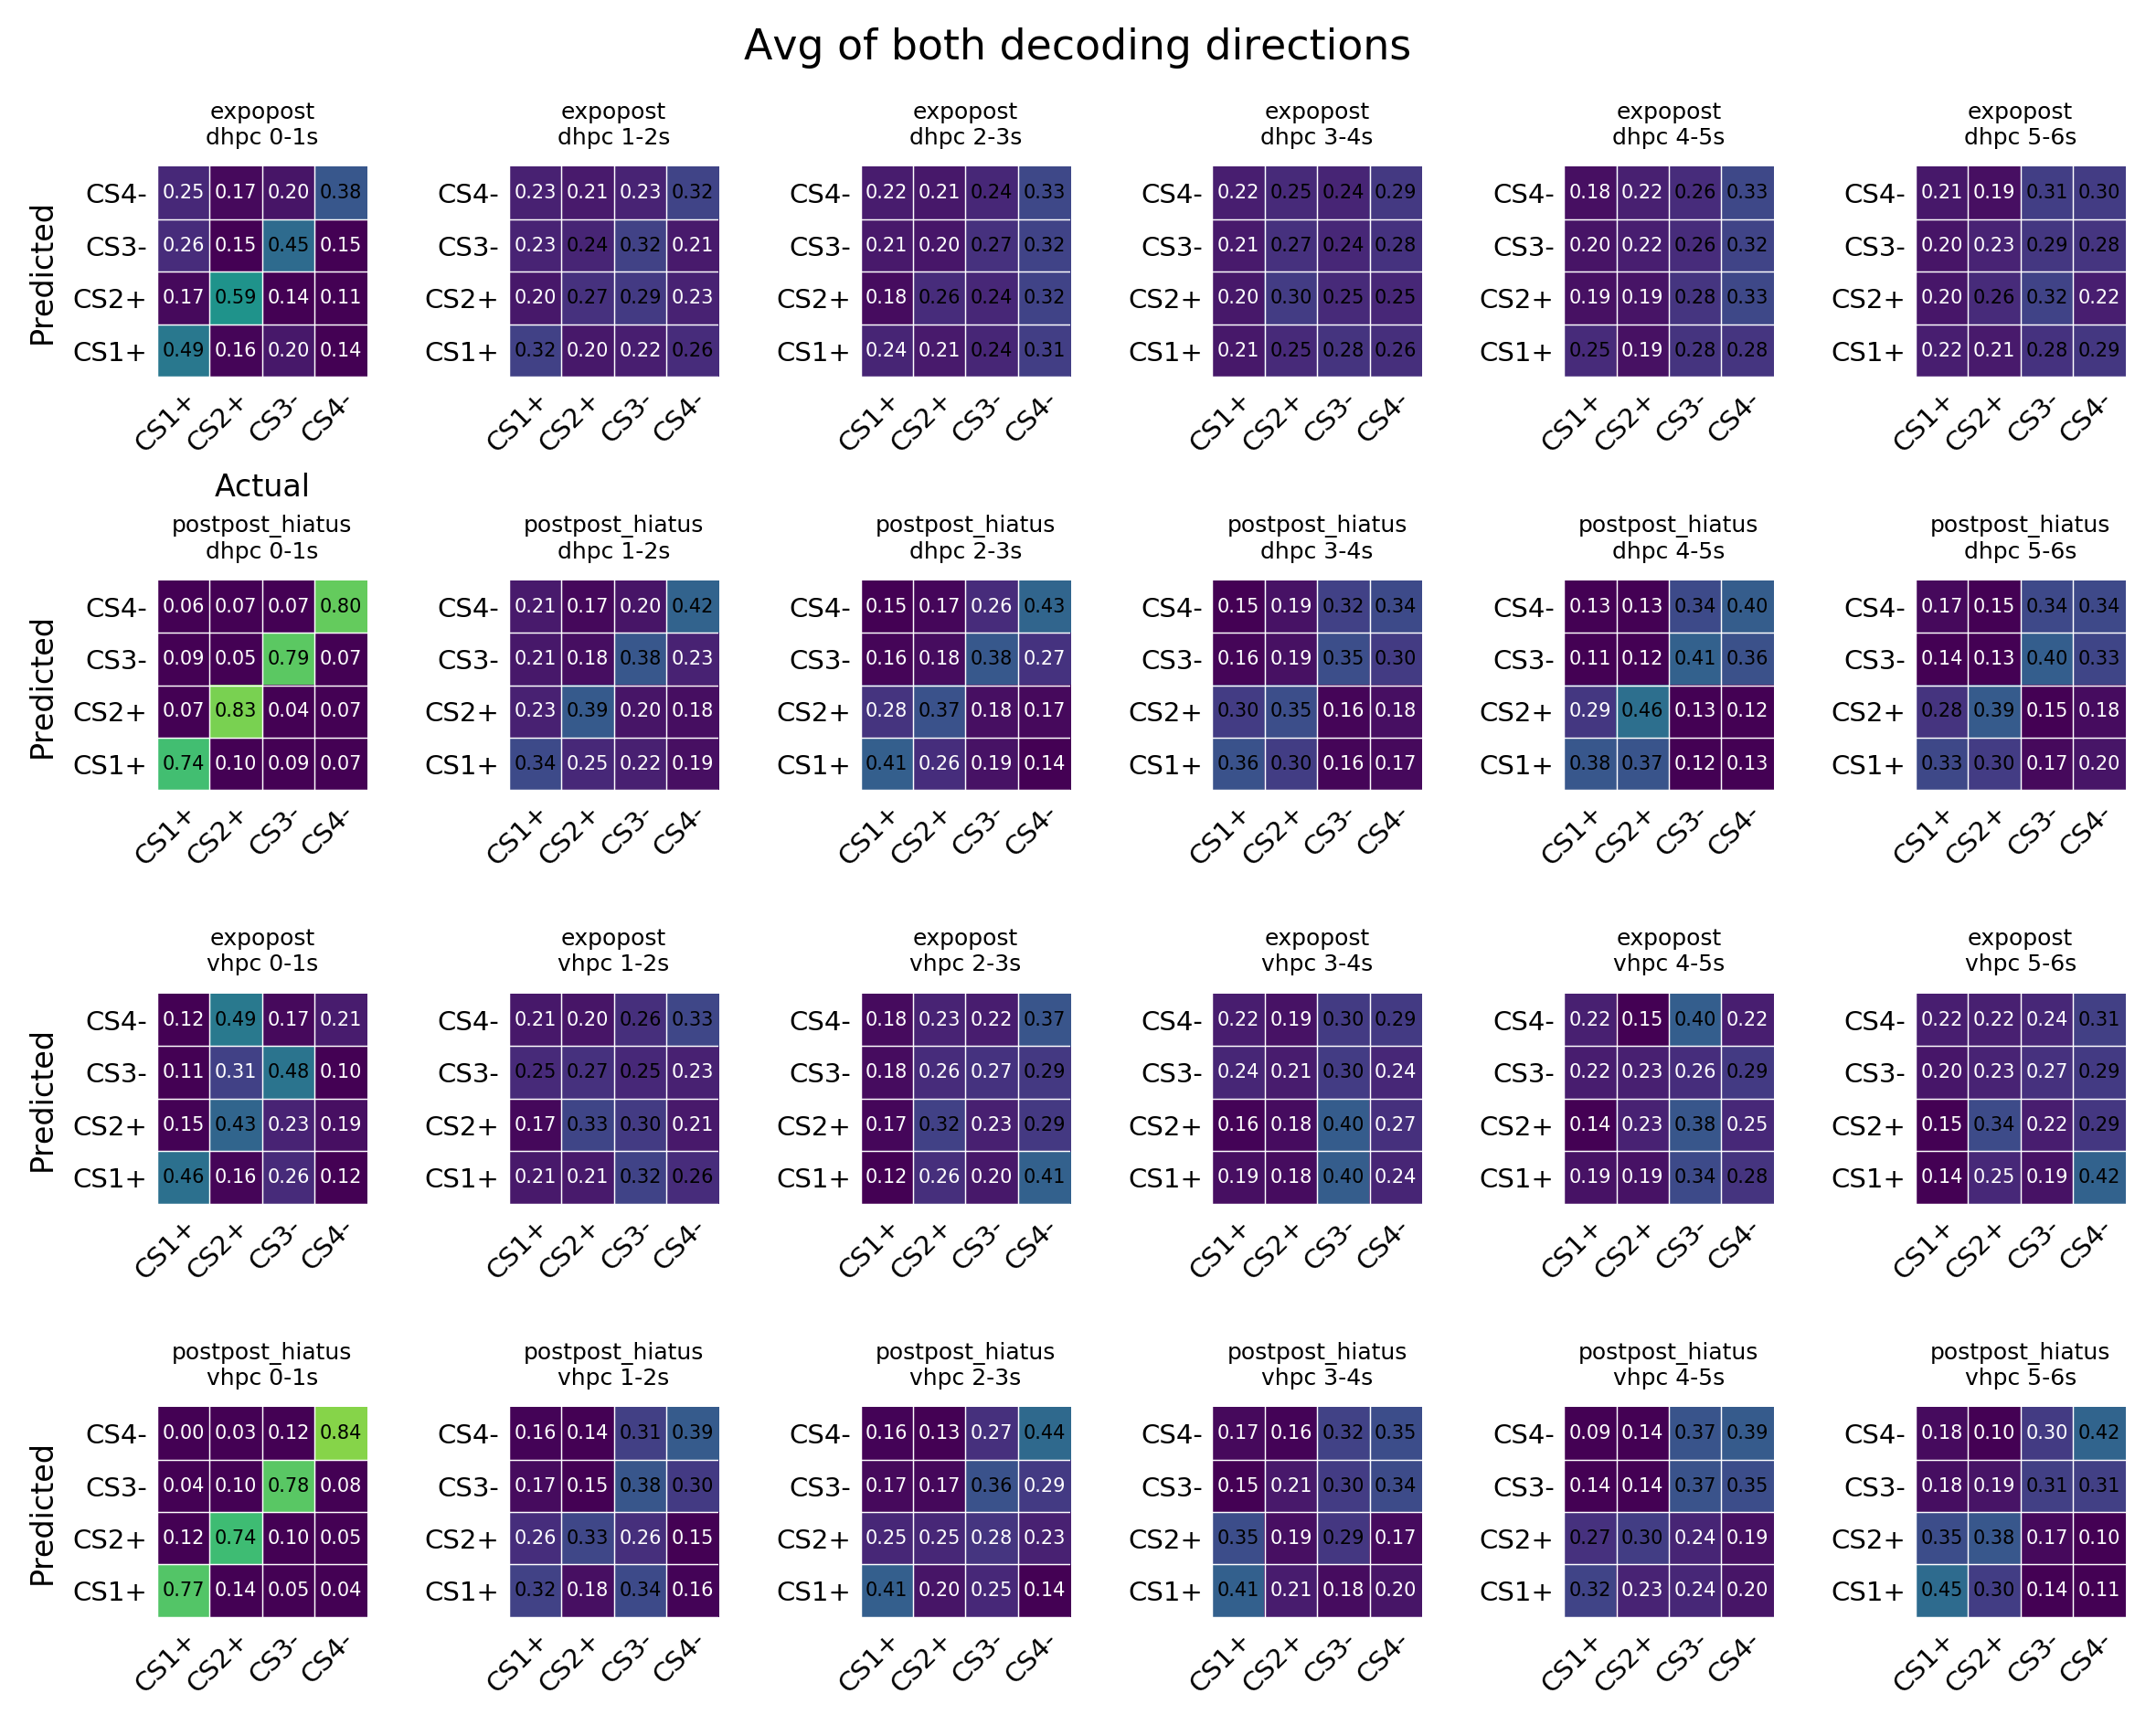

In [39]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = pl.subplots(4, 6, figsize=(8, 6))

for reg,r in zip(regions,(0,12)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['expopost','postpost_hiatus'],[0,6]):
            q=j+k+r
            im = heatmap(eval("4.*np.mean((heatmaps_test_%s_1s_%s_100cells,heatmaps_train_%s_1s_%s_100cells),0)[i]/np.sum(heatmaps_test_%s_1s_%s_100cells[i])"%(reg,comp,reg,comp,reg,comp)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                         (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0.15,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 1,:
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=8)
pl.suptitle('Avg of both decoding directions',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_4odor_cross_1s.pdf'%NOTEBOOK_NAME)

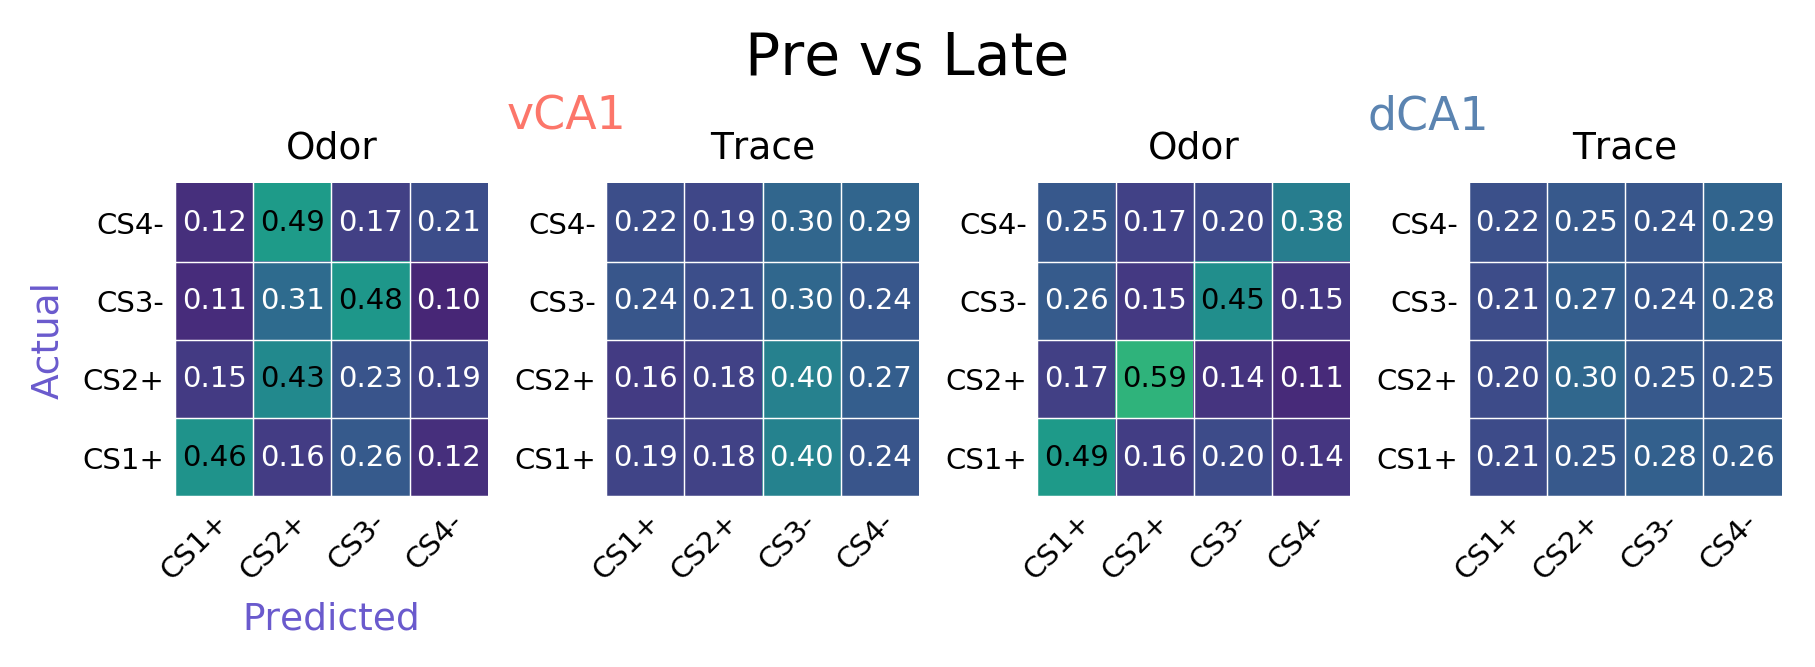

In [49]:
# plot 'em all
sess='expopost'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((5,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("4.*np.mean((heatmaps_test_%s_1s_%s_100cells,heatmaps_train_%s_1s_%s_100cells),0)[i]/\
            np.sum(heatmaps_test_%s_1s_%s_100cells[i])"%(reg,sess,reg,sess,reg,sess)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(4.5,4.2,'vCA1',color='#FC766AFF',fontsize=11,ha='center')
ax3.text(4.5,4.2,'dCA1',color='#5B84B1FF',fontsize=11,ha='center')

pl.suptitle('Pre vs Late',fontsize=14,color='k',y=.92)
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../figures/%s_confmat_dv_1s_expopost_100cells.pdf'%NOTEBOOK_NAME)

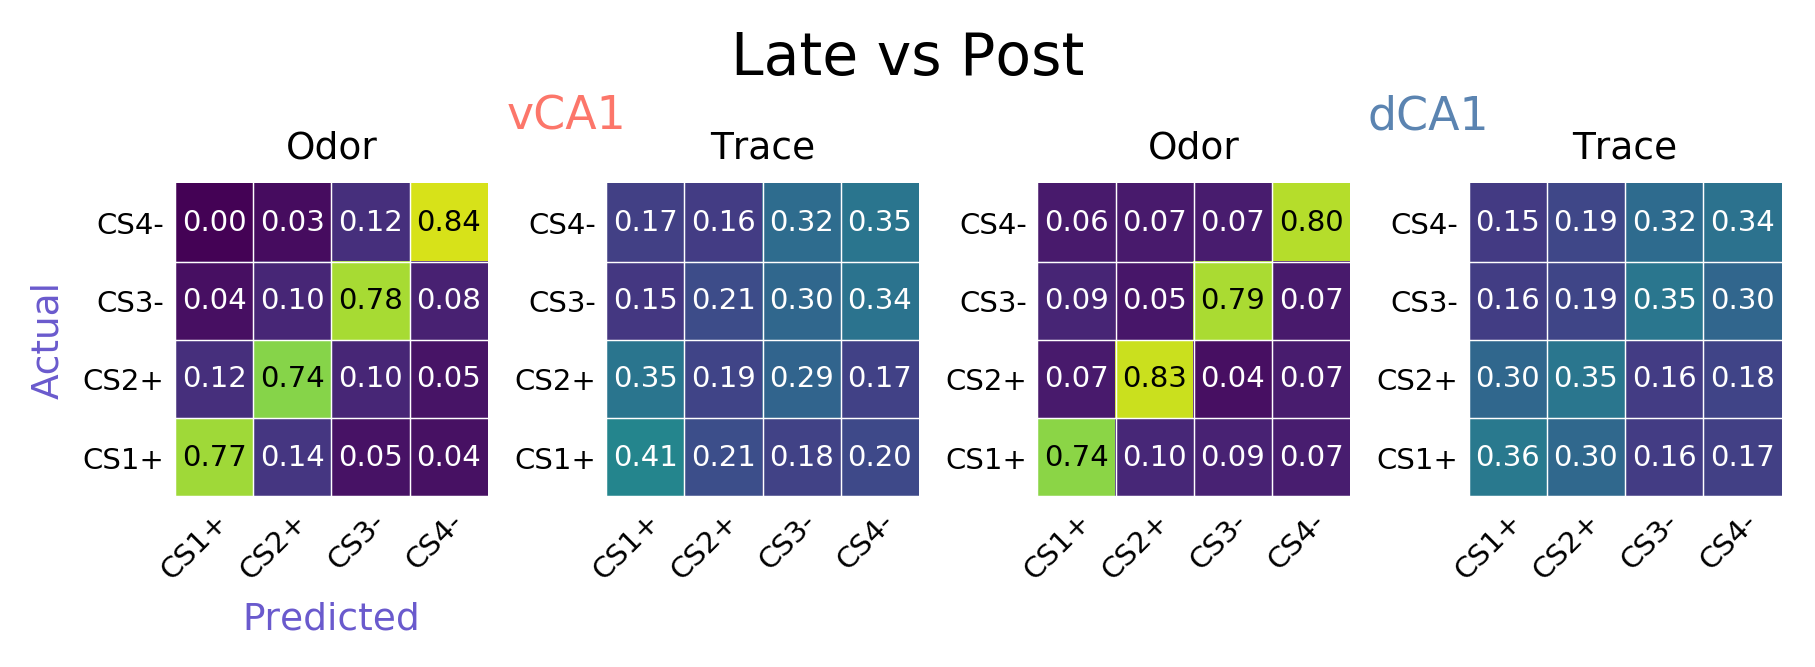

In [41]:
# plot 'em all
sess='postpost_hiatus'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((5,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("4.*np.mean((heatmaps_test_%s_1s_%s_100cells,heatmaps_train_%s_1s_%s_100cells),0)[i]/\
            np.sum(heatmaps_test_%s_1s_%s_100cells[i])"%(reg,sess,reg,sess,reg,sess)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(4.5,4.2,'vCA1',color='#FC766AFF',fontsize=11,ha='center')
ax3.text(4.5,4.2,'dCA1',color='#5B84B1FF',fontsize=11,ha='center')

pl.suptitle('Late vs Post',fontsize=14,color='k',y=.92)
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../figures/%s_confmat_dv_1s_postpost_hiatus_100cells.pdf'%NOTEBOOK_NAME)

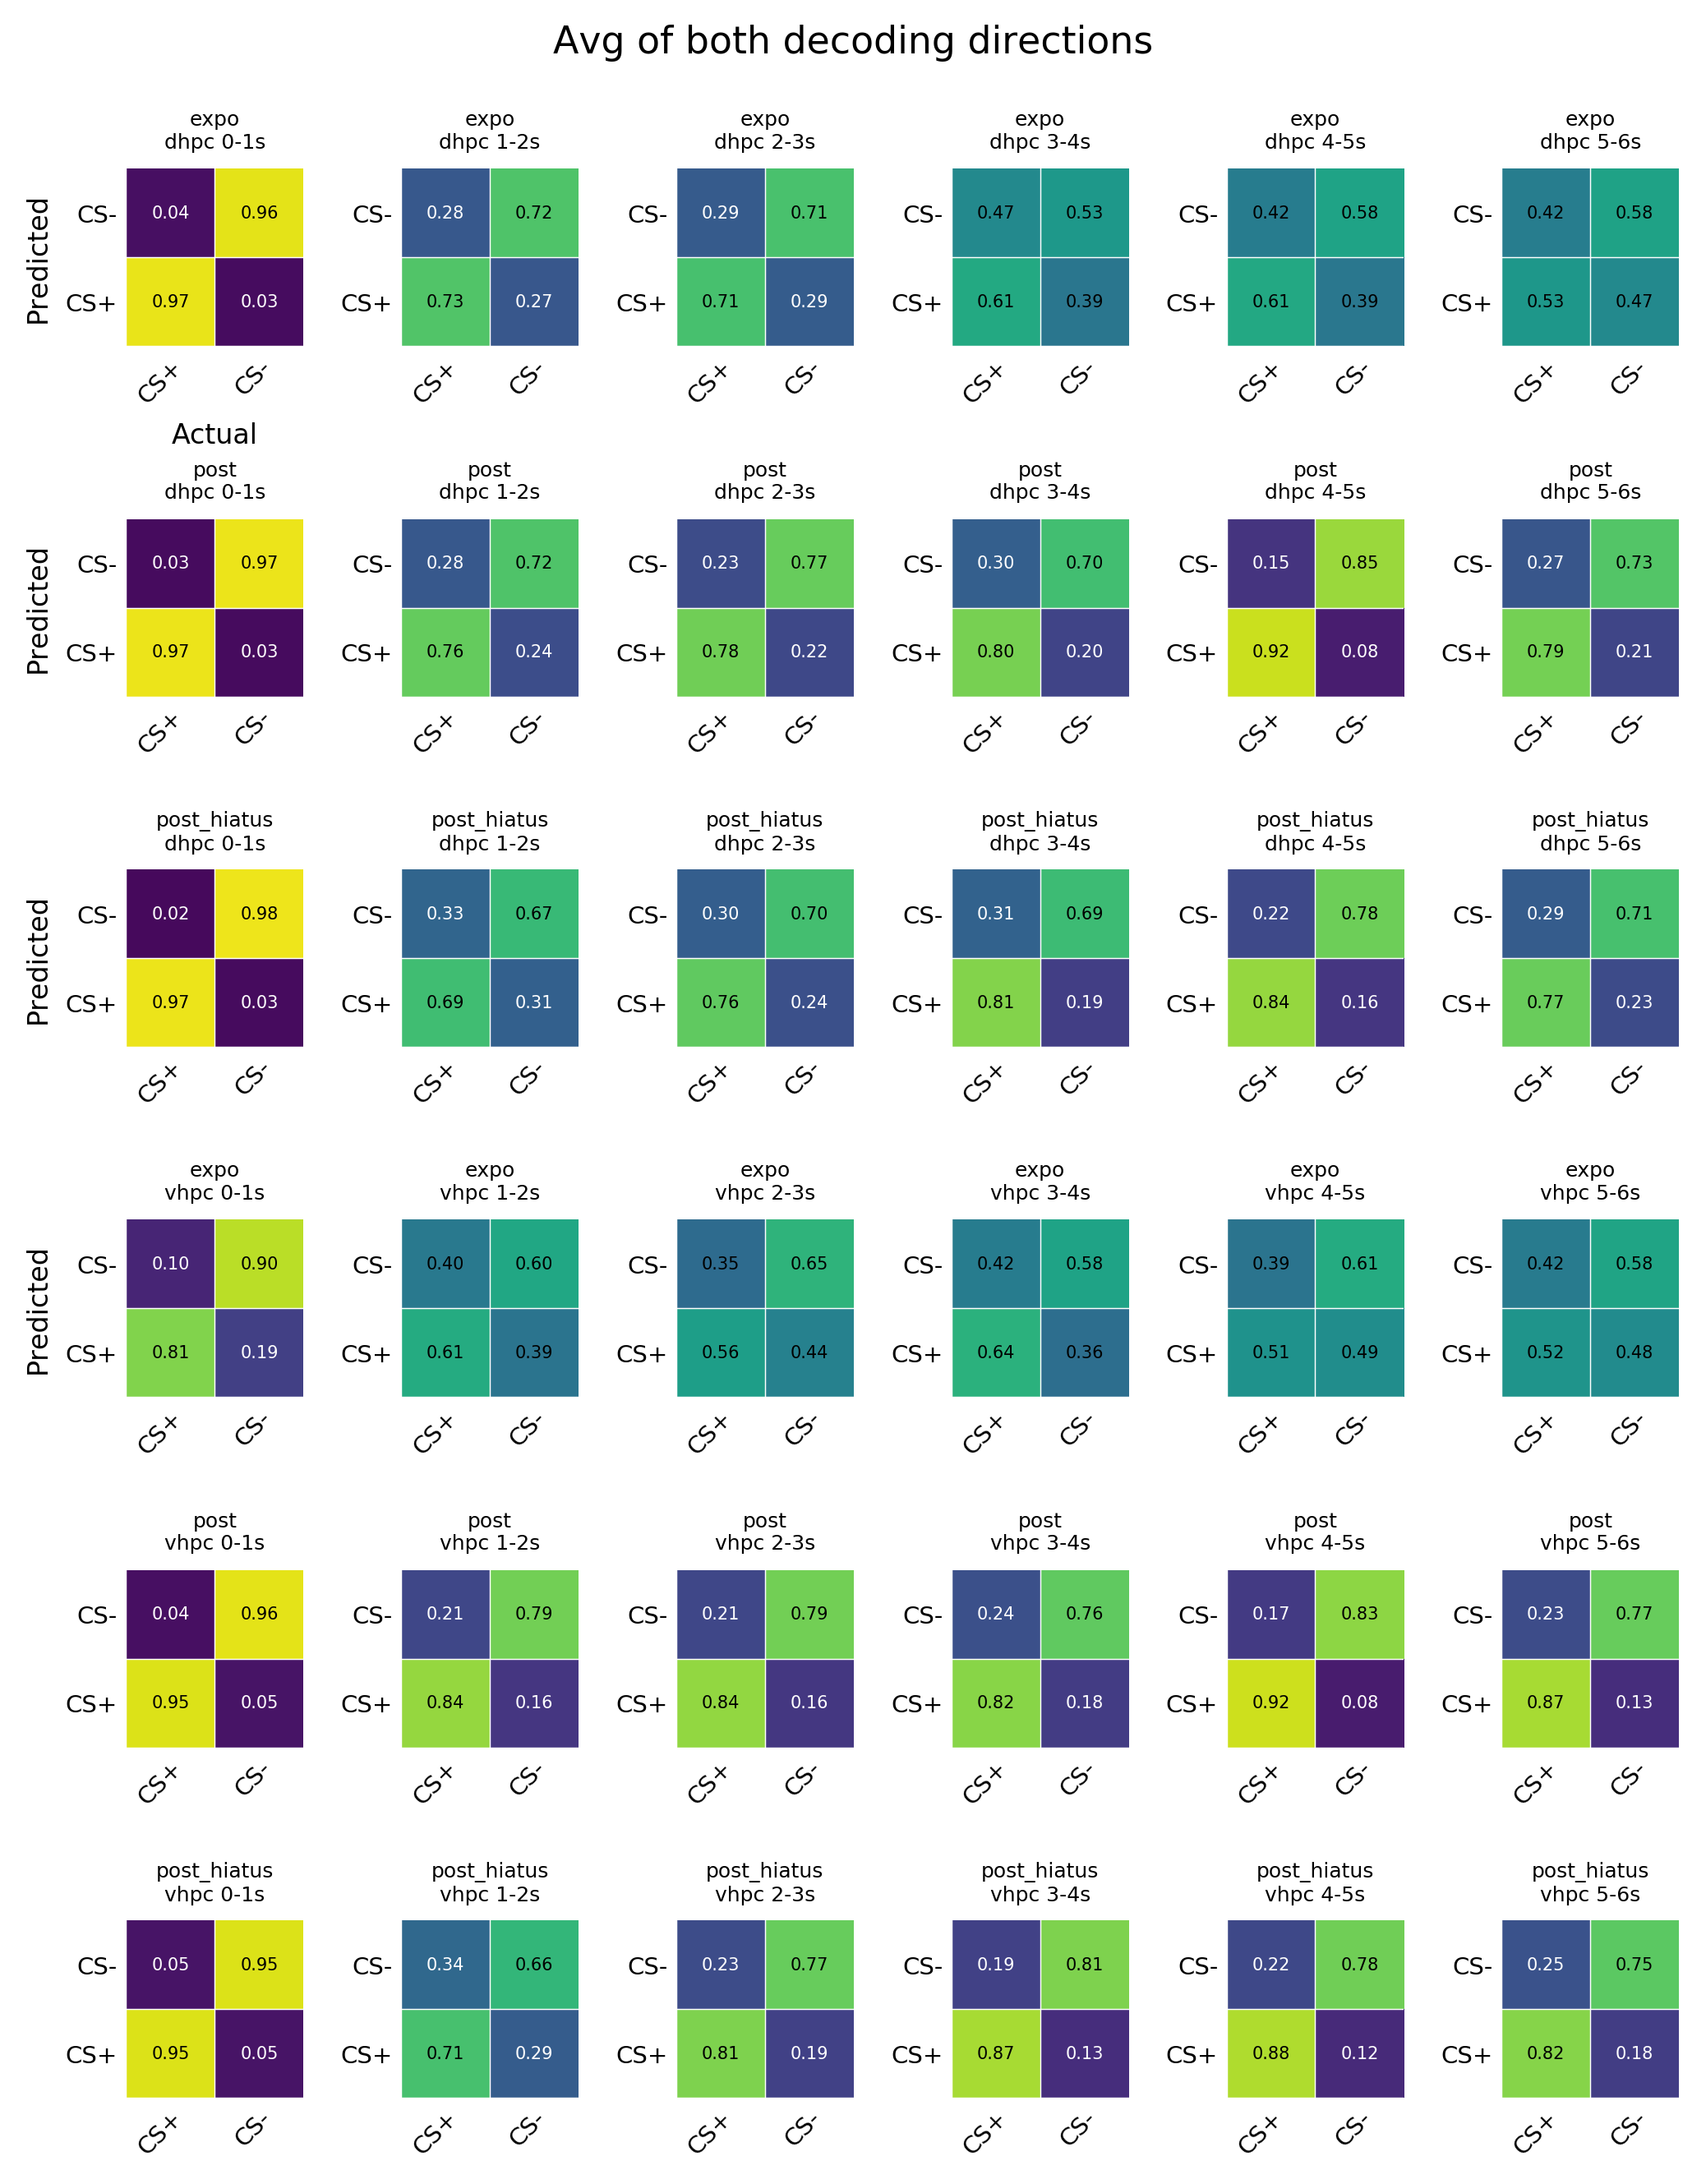

In [42]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),
      (ax19,ax20,ax21,ax22,ax23,ax24),(ax25,ax26,ax27,ax28,ax29,ax30),(ax31,ax32,ax33,ax34,ax35,ax36)) = pl.subplots(6, 6, figsize=(7, 8.5))

for reg,r in zip(regions,(0,18)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['expo','post','post_hiatus'],[0,6,12]):
            q=j+k+r
            im = heatmap(eval("2.*np.mean((CSpm_heatmaps_%s_1s_%s_100cells,CSpm_heatmaps_%s_1s_%s_100cells),0)[i]/np.sum(CSpm_heatmaps_%s_1s_%s_100cells[i])"%(reg,comp,reg,comp,reg,comp)),(['CS+','CS-']),
                         (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 1,:
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=8)
pl.suptitle('Avg of both decoding directions',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_CSpm_win_1s.pdf'%NOTEBOOK_NAME)

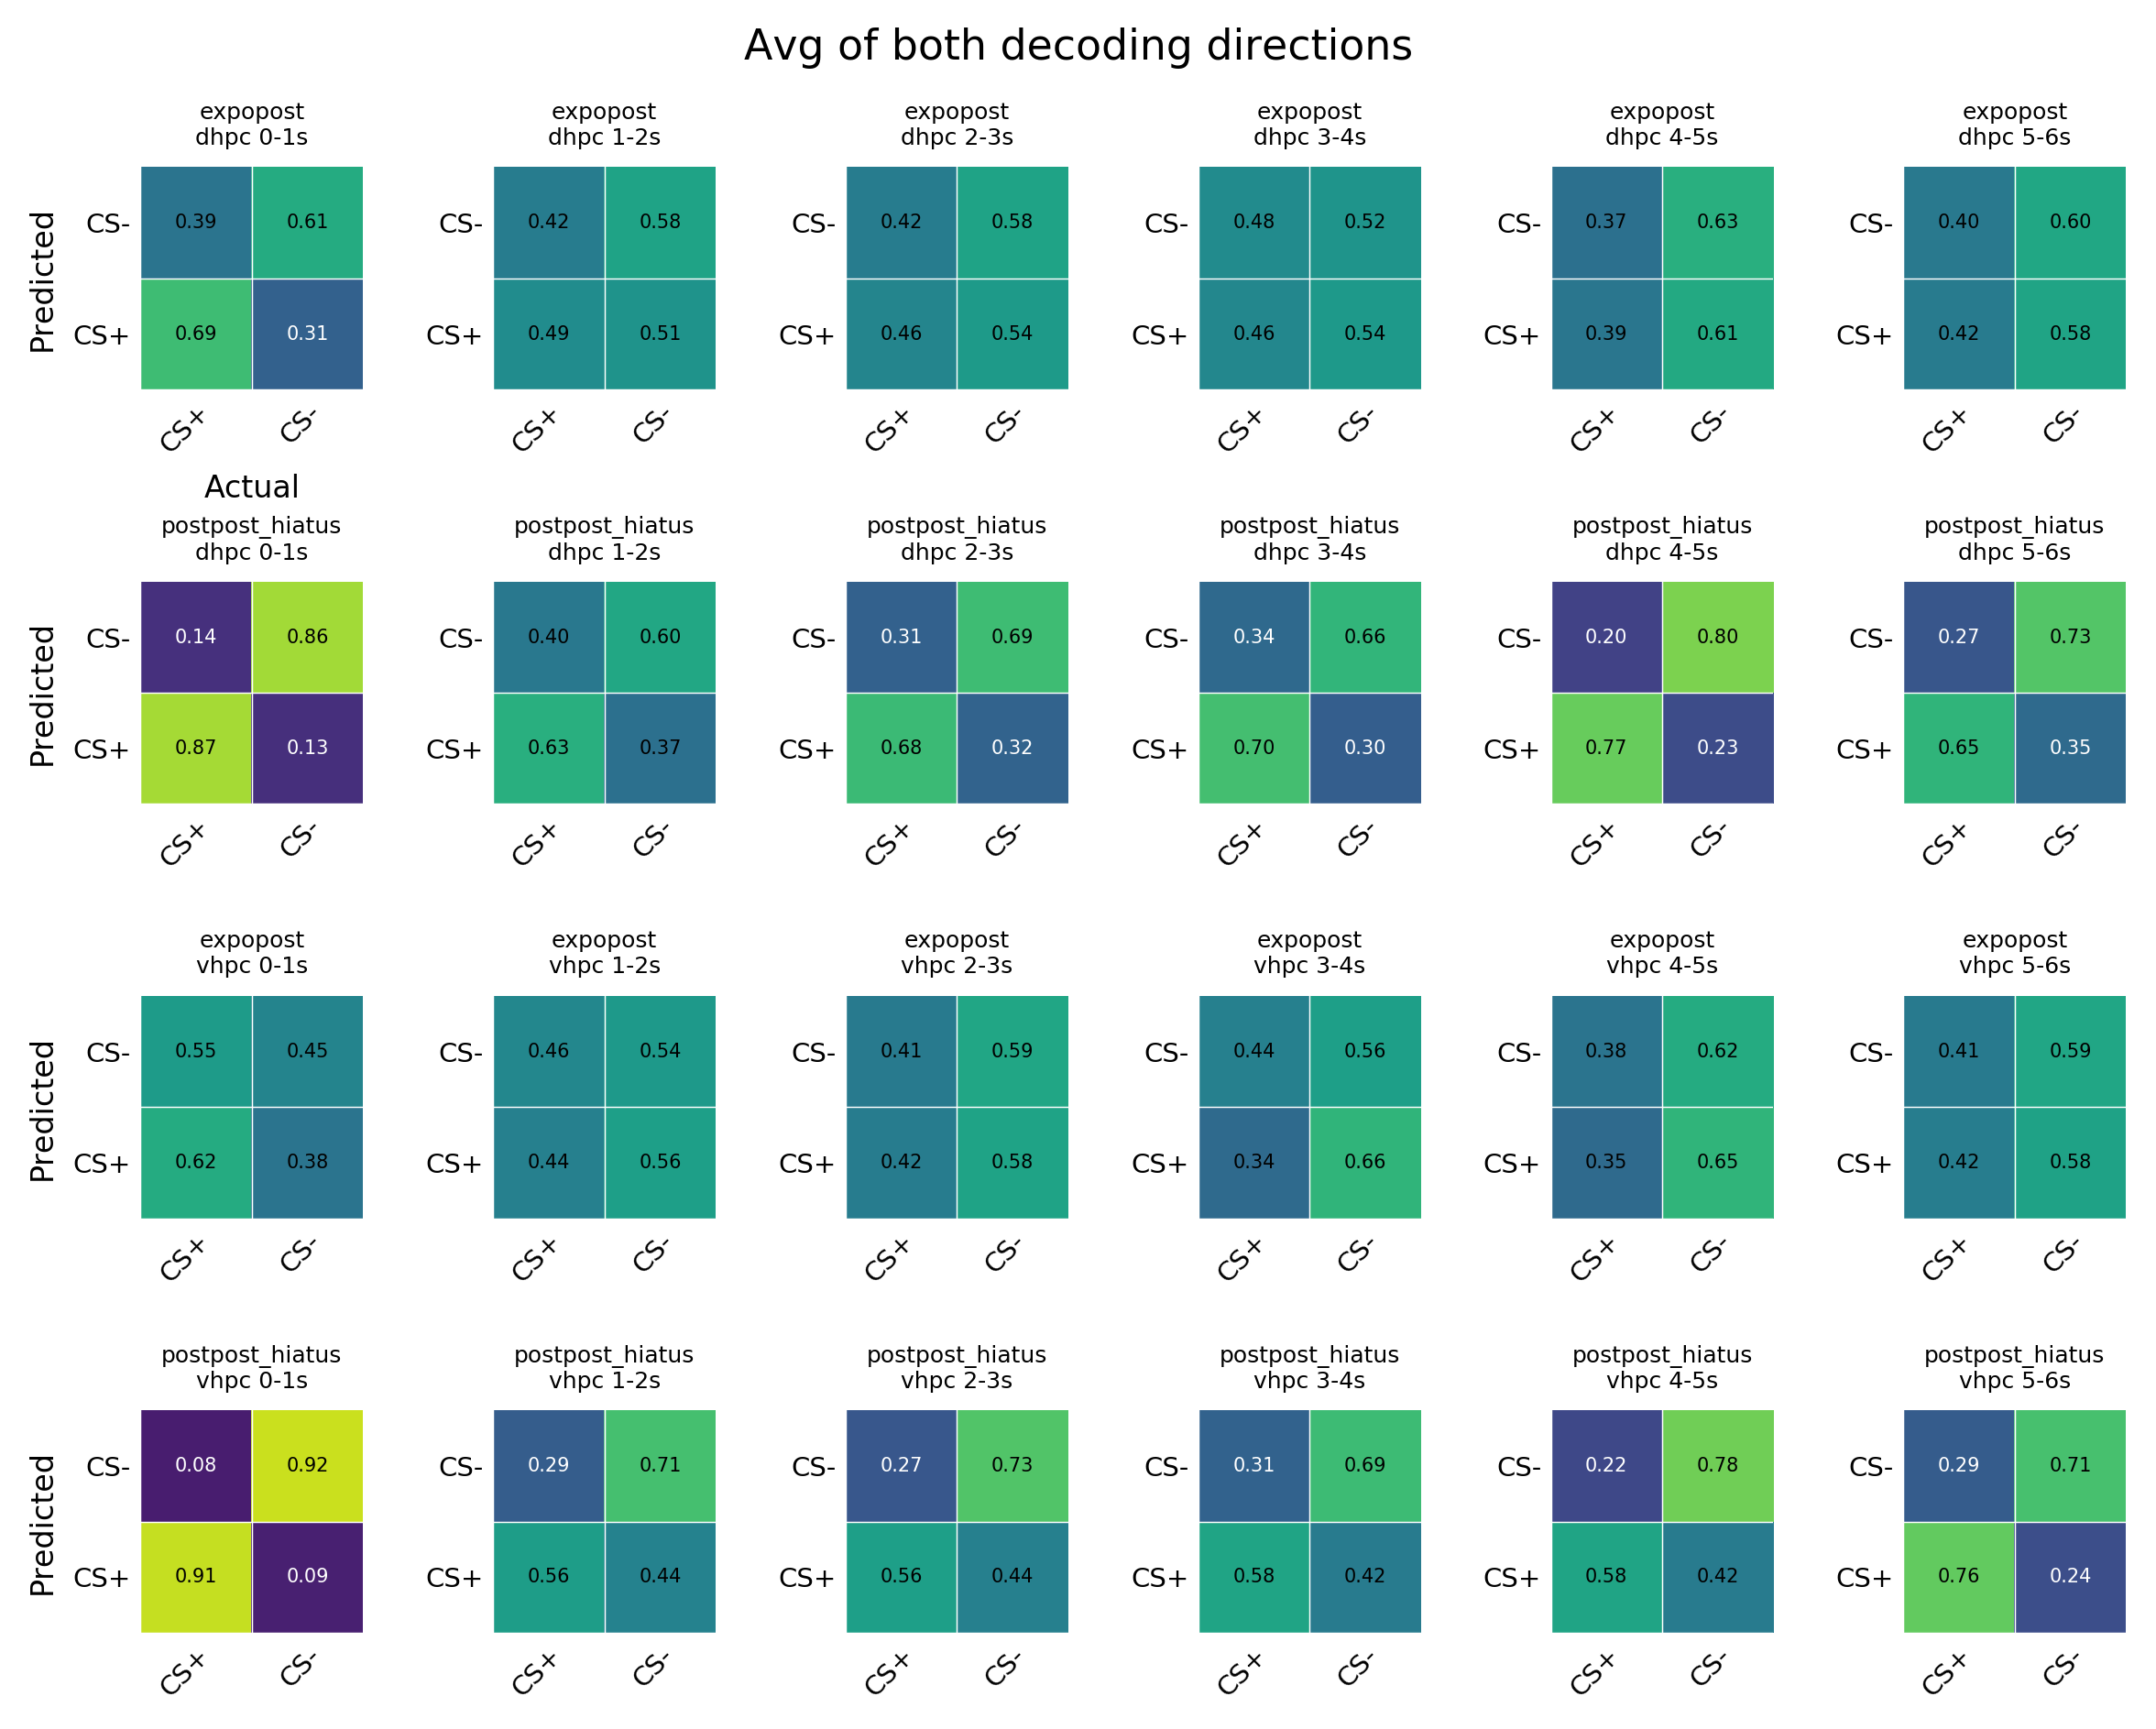

In [43]:
# plot 'em all
fig, ((ax1, ax2, ax3, ax4, ax5, ax6),(ax7,ax8,ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16,ax17,ax18),(ax19,ax20,ax21,ax22,ax23,ax24)) = pl.subplots(4, 6, figsize=(8, 6))

for reg,r in zip(regions,(0,12)):
    for i,j,la in zip(range(5,11),range(1,7),('0-1s','1-2s','2-3s','3-4s','4-5s','5-6s')):
        for comp,k in zip(['expopost','postpost_hiatus'],[0,6]):
            q=j+k+r
            im = heatmap(eval("2.*np.mean((CSpm_heatmaps_test_%s_1s_%s_100cells,CSpm_heatmaps_train_%s_1s_%s_100cells),0)[i]/np.sum(CSpm_heatmaps_test_%s_1s_%s_100cells[i])"%(reg,comp,reg,comp,reg,comp)),(['CS+','CS-']),
                         (['CS+','CS-']), ax=eval('ax%s'%q),vmin=0,vmax=1)
            annotate_heatmap(im, valfmt="{x:.2f}", size=5)
            eval('ax%s'%q).set_title(eval('"%s\\n%s %s"'%(comp,reg,la)),fontsize=6)
for x in 1,:
    eval('ax%s.set_xlabel'%x)('Actual',fontsize=8)
for x in 1,7,13,19:
    eval('ax%s.set_ylabel'%x)('Predicted',fontsize=8)
pl.suptitle('Avg of both decoding directions',fontsize=11,y=1.03)
    
pl.tight_layout(pad=2)
pl.show()
fig.savefig('../figures/%s_CSpm_cross_1s.pdf'%NOTEBOOK_NAME)

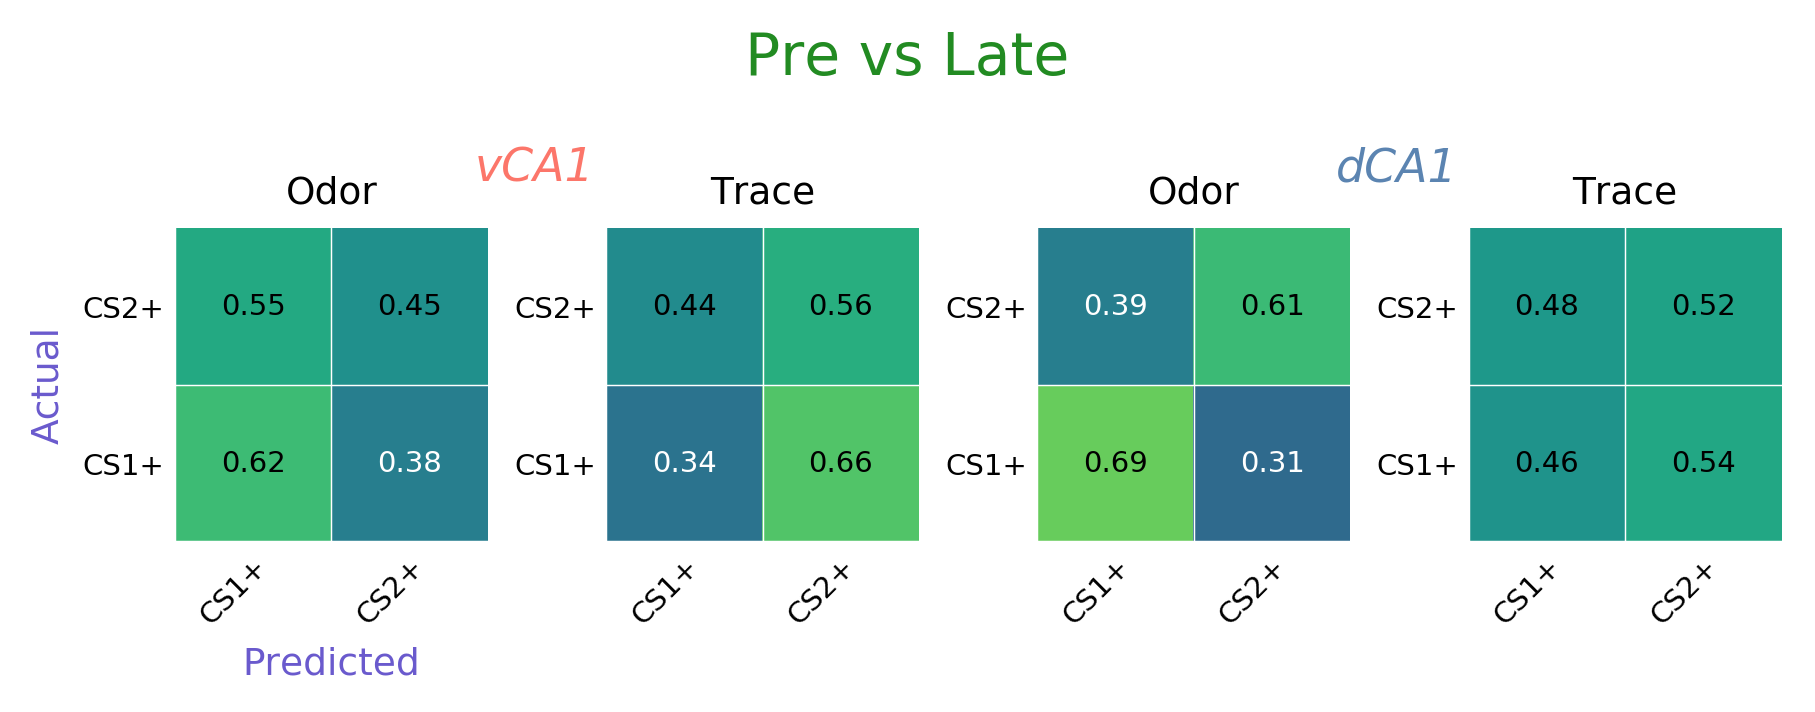

In [50]:
# plot 'em all
sess='expopost'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((5,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*np.mean((CSpm_heatmaps_test_%s_1s_%s_100cells,CSpm_heatmaps_train_%s_1s_%s_100cells),0)[i]/\
            np.sum(CSpm_heatmaps_test_%s_1s_%s_100cells[i])"%(reg,sess,reg,sess,reg,sess)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,1.8,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,1.8,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Pre vs Late',fontsize=14,color='forestgreen')
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../figures/%s_CSpm_confmat_dv_1s_expopost_100cells.pdf'%NOTEBOOK_NAME)

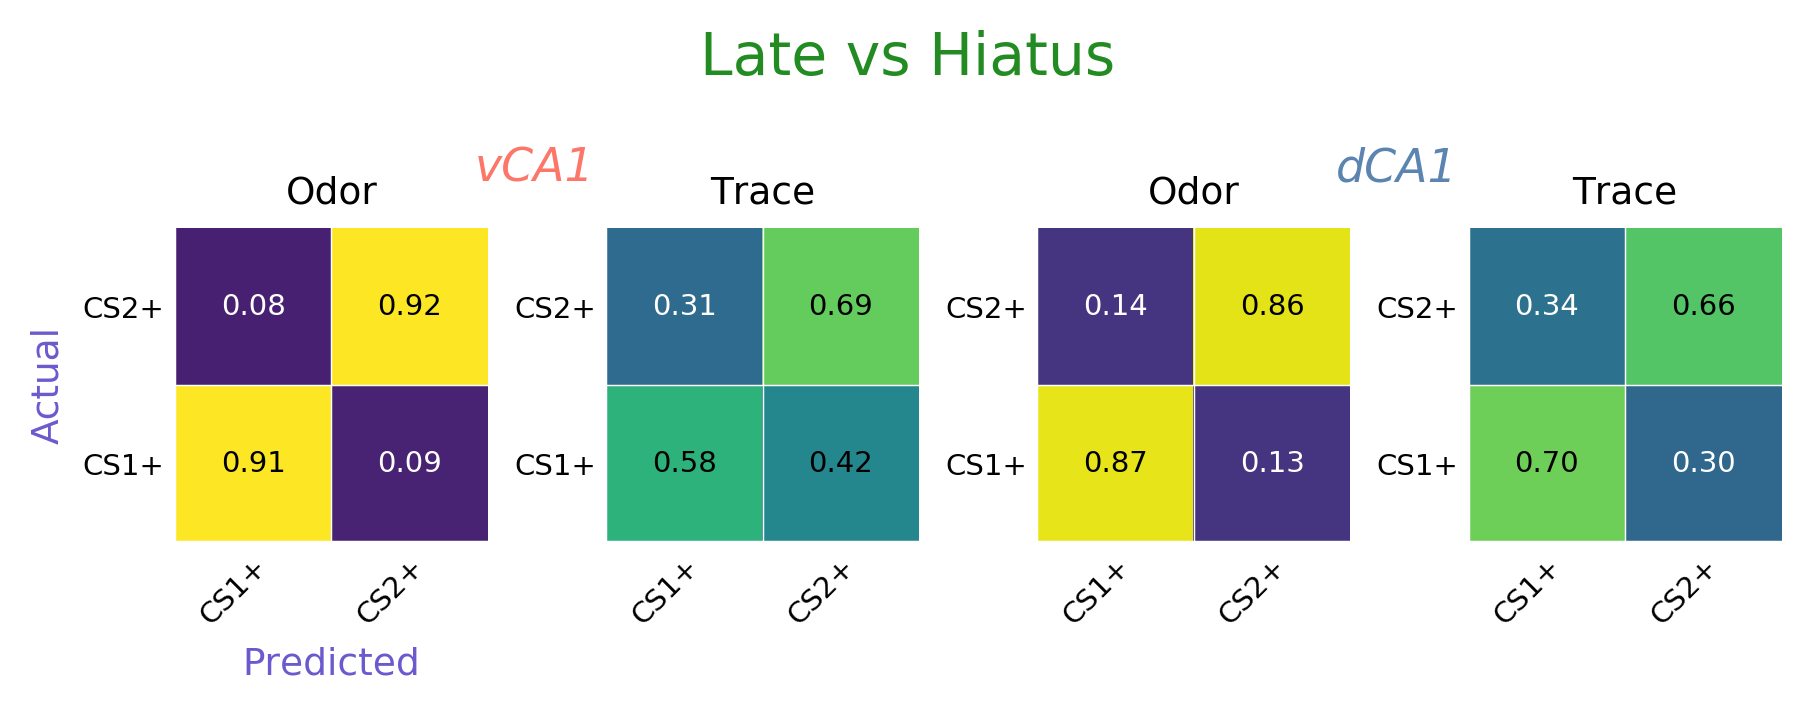

In [45]:
# plot 'em all
sess='postpost_hiatus'
fig, ((ax1, ax2, ax3, ax4)) = pl.subplots(1, 4, figsize=(6, 2.5))

for reg,r in zip(('vhpc','dhpc'),(0,2)):
    for i,j,la in zip((5,8),(1,2),('Odor','Trace')):
        q=j+r
        im = heatmap(eval("2.*np.mean((CSpm_heatmaps_test_%s_1s_%s_100cells,CSpm_heatmaps_train_%s_1s_%s_100cells),0)[i]/\
            np.sum(CSpm_heatmaps_test_%s_1s_%s_100cells[i])"%(reg,sess,reg,sess,reg,sess)),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                     (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%q),vmin=0,vmax=.9,cmap='viridis')
        annotate_heatmap(im, valfmt="{x:.2f}", size=7,threshold=.41)
        #eval('ax%s'%q).set_title(eval('"%s"'%(la)),fontsize=9)
ax1.set_title('Odor',fontsize=9)
ax2.set_title('Trace',fontsize=9)
ax3.set_title('Odor',fontsize=9)
ax4.set_title('Trace',fontsize=9)
for x in range(1,7):
    ax1.set_xlabel('Predicted',fontsize=9,color='slateblue')
    ax1.set_ylabel('Actual',fontsize=9,color='slateblue')
#pl.suptitle('vCA1',fontsize=11,y=1)
ax1.text(1.8,1.8,'vCA1',color='#FC766AFF',fontstyle='italic',fontsize=11,ha='center')
ax3.text(1.8,1.8,'dCA1',color='#5B84B1FF',fontstyle='italic',fontsize=11,ha='center')

pl.suptitle('Late vs Hiatus',fontsize=14,color='forestgreen')
pl.tight_layout(h_pad=4)
pl.show()
fig.savefig('../figures/%s_CSpm_confmat_dv_1s_postpost_hiatus_100cells.pdf'%NOTEBOOK_NAME)

# left off here

In [46]:
save_workspace(db)

Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'os'. Skipping...
